In [1]:
import anndata
import torch
import stPlus

import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd
import spatialdm as sdm

from sklearn.model_selection import KFold
from transpa.eval_util import calc_corr
from transpa.util import expTransImp, leiden_cluster, compute_autocorr
from benchmark import SpaGE_impute, Tangram_impute
import warnings

warnings.filterwarnings('ignore')
spec = "human"
ST_name = "melanoma5fold"
seed = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
spa_adata = sc.read_h5ad("../../data/ST/melanoma/spatial.h5ad")
pd.DataFrame(spa_adata.obsm['spatial'], index=spa_adata.obs_names, columns=['x','y']).to_csv(f"../../output/locations/{ST_name}.csv", index=False)
spa_adata = spa_adata[:, (spa_adata.var_names.values != 'MARCH1') & (spa_adata.var_names.values != 'MARCH2')].copy()
rna_adata = sc.read_h5ad("../../data/scRNAseq/melanoma/Tirosh_raw.h5ad")
rna_adata = rna_adata[:, (rna_adata.var_names.values != 'MARCH1') & (rna_adata.var_names.values != 'MARCH2')].copy()

In [3]:
classes, ct_list = leiden_cluster(rna_adata, False)
cls_key = 'leiden'
rna_adata.obs[cls_key] = classes
sq.gr.spatial_neighbors(spa_adata, coord_type="grid", n_neighs=4)
sq.gr.spatial_autocorr(
    spa_adata,
    n_jobs=10,
)
sc.pp.filter_genes(rna_adata, min_cells=10)
sc.pp.highly_variable_genes(spa_adata, n_top_genes=5000)
# rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
sdm.extract_lr(spa_adata, spec, min_cell=0)
spa_genes = set()
for pair in spa_adata.uns['geneInter'].interaction_name:
    _genes = pair.split('_')
    for g in _genes:
        for _g in g.split(":"):
            spa_genes.add(_g)
for gene in spa_adata.uns['moranI'].index[spa_adata.uns['moranI'].pval_norm_fdr_bh <= 0.01].values:
    spa_genes.add(gene)
    
for gene in spa_adata.var_names[spa_adata.var.highly_variable]:
    spa_genes.add(gene)
    
print(len(np.intersect1d(list(spa_genes), spa_adata.var_names)), len(spa_genes), spa_adata.n_vars)
spa_adata = spa_adata[:, np.intersect1d(list(spa_genes), spa_adata.var_names)]
rna_adata, spa_adata

5779 5820 16146


(AnnData object with n_obs × n_vars = 4645 × 21118
     obs: 'celltype', 'malignant', 'leiden'
     var: 'n_cells',
 View of AnnData object with n_obs × n_vars = 293 × 5779
     obs: 'B', 'CAF', 'Endo', 'Macro', 'Melanoma or unclassified', 'NK', 'T'
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'spatial_neighbors', 'moranI', 'hvg', 'mean', 'ligand', 'receptor', 'num_pairs', 'geneInter'
     obsm: 'spatial'
     obsp: 'spatial_connectivities', 'spatial_distances')

In [4]:
raw_spatial_df  = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)
raw_scrna_df    = pd.DataFrame(rna_adata.X, columns=rna_adata.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((293, 5779), (4645, 21118), (5380,))

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(raw_shared_gene)

df_transImpSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpCls = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpClsSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImp = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_stplus_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_spaGE_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_tangram_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)

for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):    
    print(f"\n===== Fold {idx+1} =====\nNumber of train genes: {len(train_ind)}, Number of test genes: {len(test_ind)}")
    train_gene = raw_shared_gene[train_ind]
    test_gene  = raw_shared_gene[test_ind]
    
    test_spatial_df = raw_spatial_df[test_gene]
    spatial_df = raw_spatial_df[train_gene]
    scrna_df   = raw_scrna_df

    df_transImpSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        clip_max=0.5,
        n_epochs=2000,
        mapping_mode='lowrank',
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        seed=seed,
        device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpSpa)')

    df_transImpCls[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                ct_list=ct_list,
                classes=classes,
                signature_mode='cluster',
                mapping_mode='full',
                n_epochs=2000,
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpCls)')

    df_transImp[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                signature_mode='cell',
                mapping_mode='lowrank',
                n_epochs=2000,
                clip_max=0.5,
                seed=seed,
                device=device)
    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImp)')

    df_transImpClsSpa[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                ct_list=ct_list,
                classes=classes,
                spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
                signature_mode='cluster',
                mapping_mode='full',
                n_epochs=2000,
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpClsSpa)')

    df_stplus_res[test_gene] = stPlus.stPlus(spatial_df, scrna_df, test_gene, "164894613", top_k=2000, verbose=False, random_seed=seed, device=device)
    corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_stplus)} (stPlus)')

    df_spaGE_res[test_gene]  = SpaGE_impute(scrna_df, spatial_df, train_gene, test_gene)
    corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_spaGE)} (spaGE)')

    df_tangram_res[test_gene] = Tangram_impute(rna_adata, spa_adata, train_gene, test_gene, device, cls_key)
    corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_tangram)} (Tangram)')

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, raw_shared_gene)
corr_transImp_res = calc_corr(raw_spatial_df, df_transImp, raw_shared_gene)
corr_transImpCls_res = calc_corr(raw_spatial_df, df_transImpCls, raw_shared_gene)
corr_transImpClsSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, raw_shared_gene)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, raw_shared_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, raw_shared_gene)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, raw_shared_gene)   

print(np.median(corr_transImpSpa_res), "(TransImpSpa)", 
      np.median(corr_transImp_res), "(TransImp)", 
      np.median(corr_transImpCls_res), "(TransImpCls)", 
      np.median(corr_transImpClsSpa_res), "(TransImpClsSpa)", 
      np.median(corr_res_stplus), "(stPlus)", 
      np.median(corr_res_spaGE), "(spaGE)",
      np.median(corr_res_tangram), "(Tangram)"
      )


===== Fold 1 =====
Number of train genes: 4304, Number of test genes: 1076


[TransImp] Epoch: 2000/2000, loss: 1.046413, (IMP) 1.046340, (SPA) 1.0 x 0.000073: 100%|██████████| 2000/2000 [00:10<00:00, 188.23it/s]


Median correlation: 0.055737468347158384 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.998483, (IMP) 0.998483, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:04<00:00, 449.27it/s]


Median correlation: 0.12681649136378742 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 1.022058, (IMP) 1.022058, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:09<00:00, 208.48it/s]


Median correlation: 0.12476152685086359 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 1.013164, (IMP) 1.006414, (SPA) 1.0 x 0.006751: 100%|██████████| 2000/2000 [00:06<00:00, 294.40it/s]


Median correlation: 0.10985656700106122 (TransImpClsSpa)
			nan (stPlus)
			0.10557943956678899 (spaGE)


INFO:root:4304 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:4304 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 4304 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.290, KL reg: 0.060
Score: 0.339, KL reg: 0.000
Score: 0.340, KL reg: 0.000
Score: 0.340, KL reg: 0.000
Score: 0.340, KL reg: 0.000
Score: 0.340, KL reg: 0.000
Score: 0.340, KL reg: 0.000
Score: 0.340, KL reg: 0.000
Score: 0.340, KL reg: 0.000


INFO:root:Saving results..


Score: 0.340, KL reg: 0.000
			0.12792563735266282 (Tangram)

===== Fold 2 =====
Number of train genes: 4304, Number of test genes: 1076


[TransImp] Epoch: 2000/2000, loss: 1.054259, (IMP) 1.054116, (SPA) 1.0 x 0.000143: 100%|██████████| 2000/2000 [00:09<00:00, 202.08it/s]


Median correlation: 0.057706876260384996 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 1.007547, (IMP) 1.007547, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:04<00:00, 470.38it/s]


Median correlation: 0.1340802763125537 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 1.030624, (IMP) 1.030624, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:07<00:00, 267.01it/s]


Median correlation: 0.1293192425570871 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 1.022206, (IMP) 1.015380, (SPA) 1.0 x 0.006825: 100%|██████████| 2000/2000 [00:06<00:00, 305.09it/s]


Median correlation: 0.1159079380505609 (TransImpClsSpa)
			0.04136189848428759 (stPlus)
			0.11039877370533732 (spaGE)


INFO:root:4304 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:4304 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 4304 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.291, KL reg: 0.060
Score: 0.339, KL reg: 0.000
Score: 0.340, KL reg: 0.000
Score: 0.340, KL reg: 0.000
Score: 0.340, KL reg: 0.000
Score: 0.340, KL reg: 0.000
Score: 0.340, KL reg: 0.000
Score: 0.340, KL reg: 0.000
Score: 0.340, KL reg: 0.000
Score: 0.340, KL reg: 0.000


INFO:root:Saving results..


			0.1354439133619082 (Tangram)

===== Fold 3 =====
Number of train genes: 4304, Number of test genes: 1076


[TransImp] Epoch: 2000/2000, loss: 1.035191, (IMP) 1.035061, (SPA) 1.0 x 0.000130: 100%|██████████| 2000/2000 [00:09<00:00, 202.51it/s]


Median correlation: 0.06519424804367327 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.990098, (IMP) 0.990098, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:04<00:00, 463.40it/s]


Median correlation: 0.13428263269571392 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 1.012554, (IMP) 1.012554, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:07<00:00, 263.36it/s]


Median correlation: 0.13744781026506014 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 1.004205, (IMP) 0.997590, (SPA) 1.0 x 0.006615: 100%|██████████| 2000/2000 [00:06<00:00, 301.30it/s]


Median correlation: 0.1169262991324117 (TransImpClsSpa)
			nan (stPlus)
			0.12066256676411798 (spaGE)


INFO:root:4304 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:4304 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 4304 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.291, KL reg: 0.060
Score: 0.339, KL reg: 0.000
Score: 0.339, KL reg: 0.000
Score: 0.340, KL reg: 0.000
Score: 0.340, KL reg: 0.000
Score: 0.340, KL reg: 0.000
Score: 0.340, KL reg: 0.000
Score: 0.340, KL reg: 0.000
Score: 0.340, KL reg: 0.000


INFO:root:Saving results..


Score: 0.340, KL reg: 0.000
			0.14108510722563417 (Tangram)

===== Fold 4 =====
Number of train genes: 4304, Number of test genes: 1076


[TransImp] Epoch: 2000/2000, loss: 1.052335, (IMP) 1.052055, (SPA) 1.0 x 0.000279: 100%|██████████| 2000/2000 [00:10<00:00, 197.13it/s]


Median correlation: 0.06555773572143009 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 1.009105, (IMP) 1.009105, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:04<00:00, 454.12it/s]


Median correlation: 0.13482331418706936 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 1.031347, (IMP) 1.031347, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:07<00:00, 266.57it/s]


Median correlation: 0.1301171303750303 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 1.023268, (IMP) 1.016771, (SPA) 1.0 x 0.006497: 100%|██████████| 2000/2000 [00:06<00:00, 300.15it/s]


Median correlation: 0.11640599669702131 (TransImpClsSpa)
			nan (stPlus)
			0.1138887375837359 (spaGE)


INFO:root:4304 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:4304 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 4304 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.290, KL reg: 0.060
Score: 0.337, KL reg: 0.000
Score: 0.338, KL reg: 0.000
Score: 0.338, KL reg: 0.000
Score: 0.338, KL reg: 0.000
Score: 0.338, KL reg: 0.000
Score: 0.338, KL reg: 0.000
Score: 0.338, KL reg: 0.000
Score: 0.339, KL reg: 0.000


INFO:root:Saving results..


Score: 0.339, KL reg: 0.000
			0.1367416997230908 (Tangram)

===== Fold 5 =====
Number of train genes: 4304, Number of test genes: 1076


[TransImp] Epoch: 2000/2000, loss: 1.042727, (IMP) 1.042288, (SPA) 1.0 x 0.000439: 100%|██████████| 2000/2000 [00:09<00:00, 201.66it/s]


Median correlation: 0.06958188126851397 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 1.001439, (IMP) 1.001439, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:04<00:00, 467.79it/s]


Median correlation: 0.13662245681058421 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 1.022249, (IMP) 1.022249, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:07<00:00, 265.53it/s]


Median correlation: 0.12992820248202247 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 1.015643, (IMP) 1.009036, (SPA) 1.0 x 0.006607: 100%|██████████| 2000/2000 [00:06<00:00, 301.03it/s]


Median correlation: 0.11834827329483927 (TransImpClsSpa)
			0.0629992274300188 (stPlus)
			0.11647383734244501 (spaGE)


INFO:root:4304 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:4304 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 4304 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.290, KL reg: 0.060
Score: 0.338, KL reg: 0.000
Score: 0.339, KL reg: 0.000
Score: 0.339, KL reg: 0.000
Score: 0.339, KL reg: 0.000
Score: 0.339, KL reg: 0.000
Score: 0.339, KL reg: 0.000
Score: 0.339, KL reg: 0.000
Score: 0.339, KL reg: 0.000


INFO:root:Saving results..


Score: 0.339, KL reg: 0.000
			0.13281139407007583 (Tangram)
0.0633785890091868 (TransImpSpa) 0.12965717623773154 (TransImp) 0.13337285744639116 (TransImpCls) 0.11571400200474513 (TransImpClsSpa) nan (stPlus) 0.11309646032234724 (spaGE) 0.13510979046228647 (Tangram)


In [6]:
df_transImp.to_csv(f'../../output/{ST_name}_{ST_name}_TransImp.csv')
df_transImpSpa.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpSpa.csv')
df_transImpCls.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpCls.csv')
df_transImpClsSpa.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpClsSpa.csv')
df_spaGE_res.to_csv(f'../../output/{ST_name}_{ST_name}_spaGE.csv')
df_stplus_res.to_csv(f'../../output/{ST_name}_{ST_name}_stPlus.csv')
df_tangram_res.to_csv(f'../../output/{ST_name}_{ST_name}_Tangram.csv')
raw_spatial_df[raw_shared_gene].to_csv(f'../../output/{ST_name}_{ST_name}_truth.csv')


In [7]:
dict_df = {
            "TransImp":df_transImp, 
           "TransImpSpa":df_transImpSpa, 
           "TransImpCls":df_transImpCls,
           "TransImpClsSpa":df_transImpClsSpa,
           "spaGE": df_spaGE_res, 
           "stPlus": df_stplus_res,
            "Tangram":df_tangram_res,
            "truth":raw_spatial_df[raw_shared_gene].copy(),
            }
spa_adata.X = spa_adata.X.toarray()
sq.gr.spatial_autocorr(
    spa_adata,
    genes=spa_adata.var_names,
    n_jobs=10,
)

dict_adata = {name: compute_autocorr(spa_adata[:, raw_shared_gene].copy(), df) for name, df in dict_df.items()}


In [8]:
from sklearn.metrics import mean_squared_error
moranIs = {name:mean_squared_error(spa_adata.uns['moranI'].loc[raw_shared_gene].I, imp_adata.uns['moranI'].loc[raw_shared_gene].I) for name, imp_adata in dict_adata.items() if name != 'stPlus'}

print("Mean Squared Error\nMoran's I:\n")
print("\n".join([f"\tTrue vs {method}: {score:.6f}" for method, score in moranIs.items()]))



Mean Squared Error
Moran's I:

	True vs TransImp: 0.226597
	True vs TransImpSpa: 0.008705
	True vs TransImpCls: 0.277497
	True vs TransImpClsSpa: 0.007310
	True vs spaGE: 0.122510
	True vs Tangram: 0.182276
	True vs truth: 0.000000


In [9]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import seaborn as sns
import os
import torch
import pickle


from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import warnings

color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
methods = ['truth', 'Tangram', 'TransImp', 'TransImpSpa', 'spaGE', 'stPlus',  'TransImpCls', 'TransImpClsSpa']
warnings.filterwarnings('ignore')

eval_res_path = f"../../output/{ST_name}ext_small_train_eval_results.pkl"
is_reeval = True

seed = 10
thred = 0.01

In [10]:
if is_reeval:
    df_spa = dict_df['truth']
    imp_adatas = {}
    eval_res = {'se_moranI':{}, 'pred_corr':{}, 'fdr':{}, 'I':{}, 'pval':{}}
    for method  in tqdm(methods):
        
        imp_adata = dict_adata[method]
        df_res = dict_df[method]
        corrs = calc_corr(df_spa, df_res, df_res.columns)
        sq.gr.spatial_neighbors(imp_adata, coord_type ='grid', n_neighs=4)
        sq.gr.spatial_autocorr(
            imp_adata,
            genes=imp_adata.var_names,
            n_jobs=20,
            mode='moran',
        )

        if not is_reeval:
            continue
        
        fdr = imp_adata.uns['moranI'].pval_norm_fdr_bh.values
        squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I.values - imp_adata.uns['moranI'].I.values)
        eval_res['se_moranI'][method] = squ_err_moranI
        eval_res['pred_corr'][method] = pd.Series(np.array(corrs), df_res.columns)
        eval_res['fdr'][method] = pd.Series(fdr, df_res.columns)
        eval_res['pval'][method] = pd.Series(imp_adata.uns['moranI'].pval_norm, df_res.columns)
        eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I, df_res.columns)
       
    with open(eval_res_path, 'wb') as outfile:
        pickle.dump((eval_res, spa_adata, dict_adata), outfile)

100%|██████████| 8/8 [00:20<00:00,  2.55s/it]


In [11]:
df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_fdr     = pd.DataFrame(dict(sorted(eval_res['fdr'].items())))
df_pval     = pd.DataFrame(dict(sorted(eval_res['pval'].items())))
df_I     = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_fdr['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].pval_norm_fdr_bh
df_I['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].I
df_pval['truth'] = spa_adata.uns['moranI'].loc[df_pval.index.values,:].pval_norm

imp_adatas = dict(sorted(imp_adatas.items()))
df_fdr, df_pval

(          Tangram  TransImp  TransImpCls  TransImpClsSpa   TransImpSpa  \
 A1BG     0.000000  0.000000     0.000000        0.014624  0.000000e+00   
 A2M      0.000000  0.000000     0.000000        0.014624  2.986500e-13   
 A4GALT   0.000000  0.000000     0.000000        0.014624  1.592800e-12   
 AAED1    0.000000  0.000000     0.000000        0.014624  2.881972e-11   
 AAK1     0.000000  0.000000     0.000000        0.014624  7.561818e-11   
 ...           ...       ...          ...             ...           ...   
 ZSCAN5A  0.306496  0.486885     0.423952        0.113215  2.476774e-04   
 ZSWIM5   0.374989  0.412415     0.377951        0.110267  1.049722e-04   
 ZSWIM6   0.375427  0.383845     0.188037        0.105829  4.348247e-05   
 ZSWIM7   0.303309  0.140757     0.142837        0.093241  2.660302e-05   
 ZUFSP    0.285060  0.126398     0.142660        0.034991  8.991137e-07   
 
             spaGE  stPlus         truth  
 A1BG     0.000000     NaN  5.000000e-01  
 A2M      0.

(Tangram) Valid genes: 2681/5380
0
Tangram
(Tangram) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (2654/2681)
FPR: 0.986993
(TransImp) Valid genes: 2681/5380
0
TransImp
(TransImp) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (2649/2681)
FPR: 0.984912
(TransImpSpa) Valid genes: 2681/5380
0
TransImpSpa
(TransImpSpa) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (339/2681)
FPR: 0.133195
(spaGE) Valid genes: 2681/5380
0
spaGE
(spaGE) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (2449/2681)
FPR: 0.903746
(stPlus) Valid genes: 2681/5380
2681
stPlus
(stPlus) Valid genes: 2681/5380, Ground Sig/Total (759/2681), Pred Sig/total (0/2681)
FPR: 0.000000


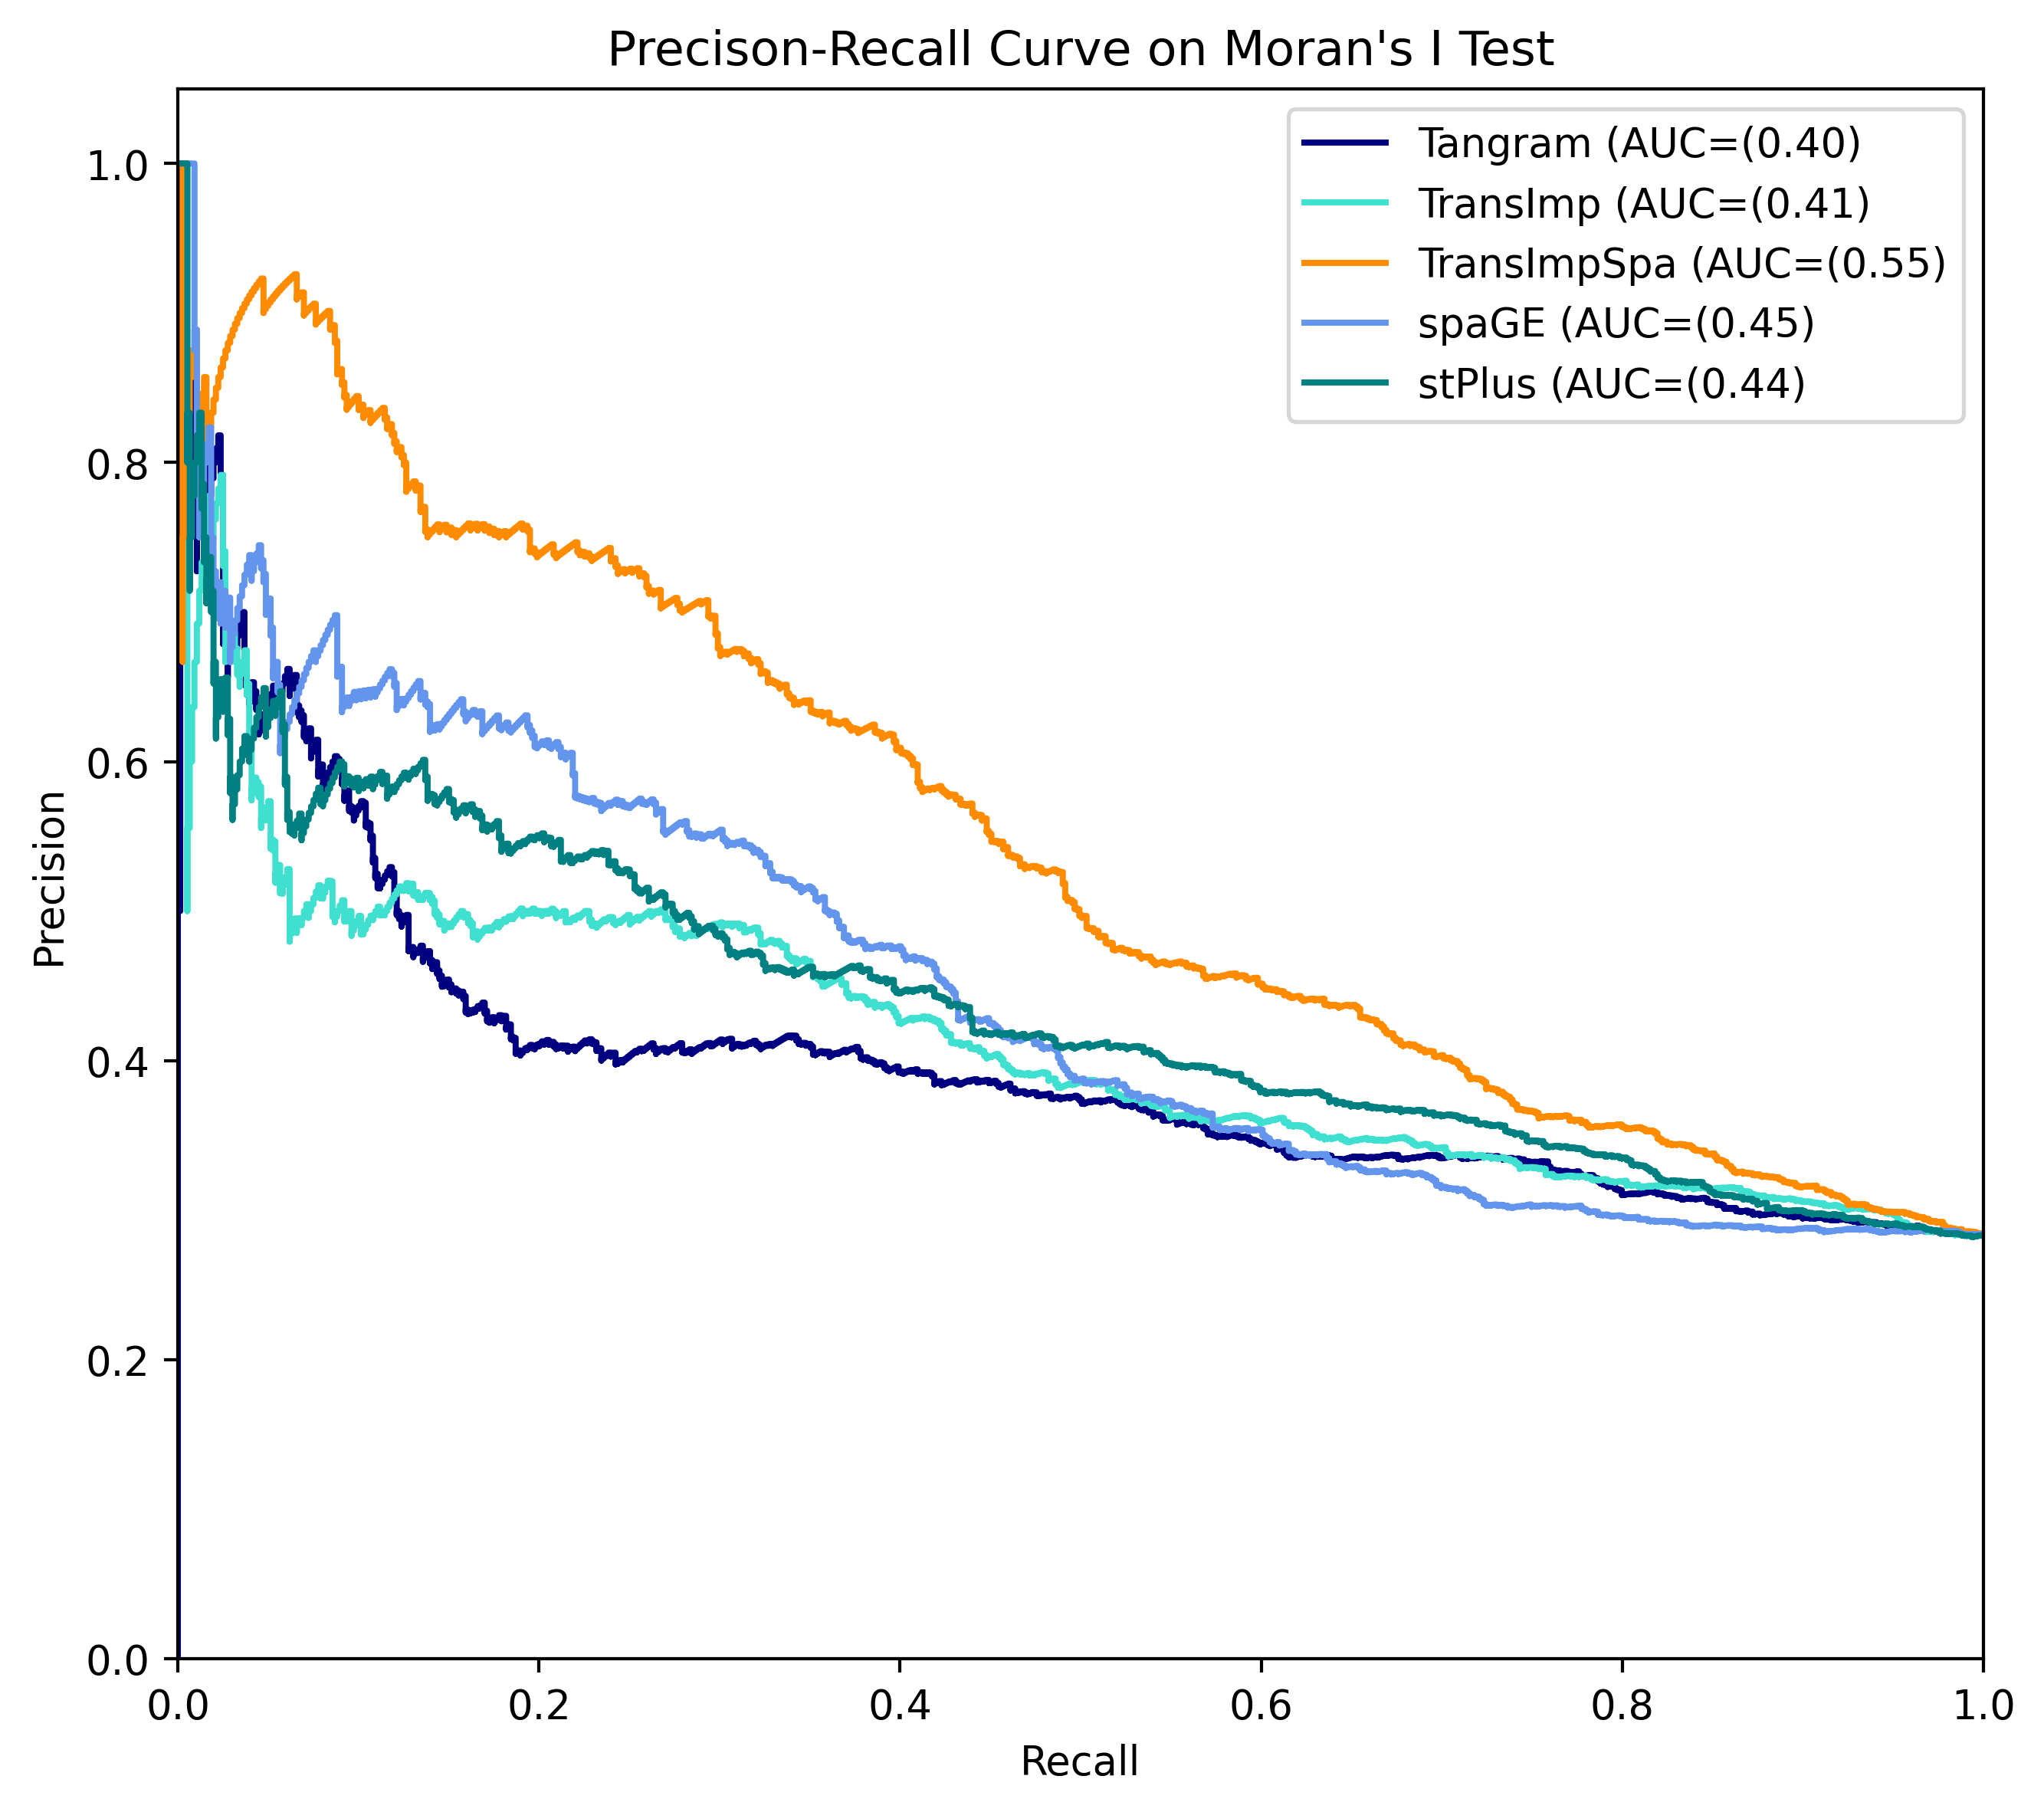

In [12]:
from sklearn import metrics
from matplotlib import pyplot as plt

idx = -1

plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa', 'truth'}: continue
    sel = (~np.isnan(df_I['truth'].values) ) & (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, preds_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
    score = df_I[method][sel]
    # score = -np.log(df_pval[method][sel] + min(df_pval[method][sel].min()/1e6, 1e-300))
    score[np.isinf(score)] = score[~np.isinf(score)].max()*10
    print(np.isnan(preds_pval).sum())
    # plt.hist(fdr, bins=100)
    print(method)
    preds = preds_pval < thred
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}, Ground Sig/Total ({(truth_pval < thred).sum()}/{truth_pval.shape[0]}), Pred Sig/total ({(preds_pval < thred).sum()}/{preds_pval.shape[0]})')
    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpClsSpa", 'truth'}:
        idx += 1
    else:
        continue     
    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on Moran's I Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 2681/5380
Tangram
FPR: 0.986993
(TransImp) Valid genes: 2681/5380
TransImp
FPR: 0.984912
(TransImpSpa) Valid genes: 2681/5380
TransImpSpa
FPR: 0.133195
(spaGE) Valid genes: 2681/5380
spaGE
FPR: 0.903746
(stPlus) Valid genes: 2681/5380
stPlus
FPR: 0.000000


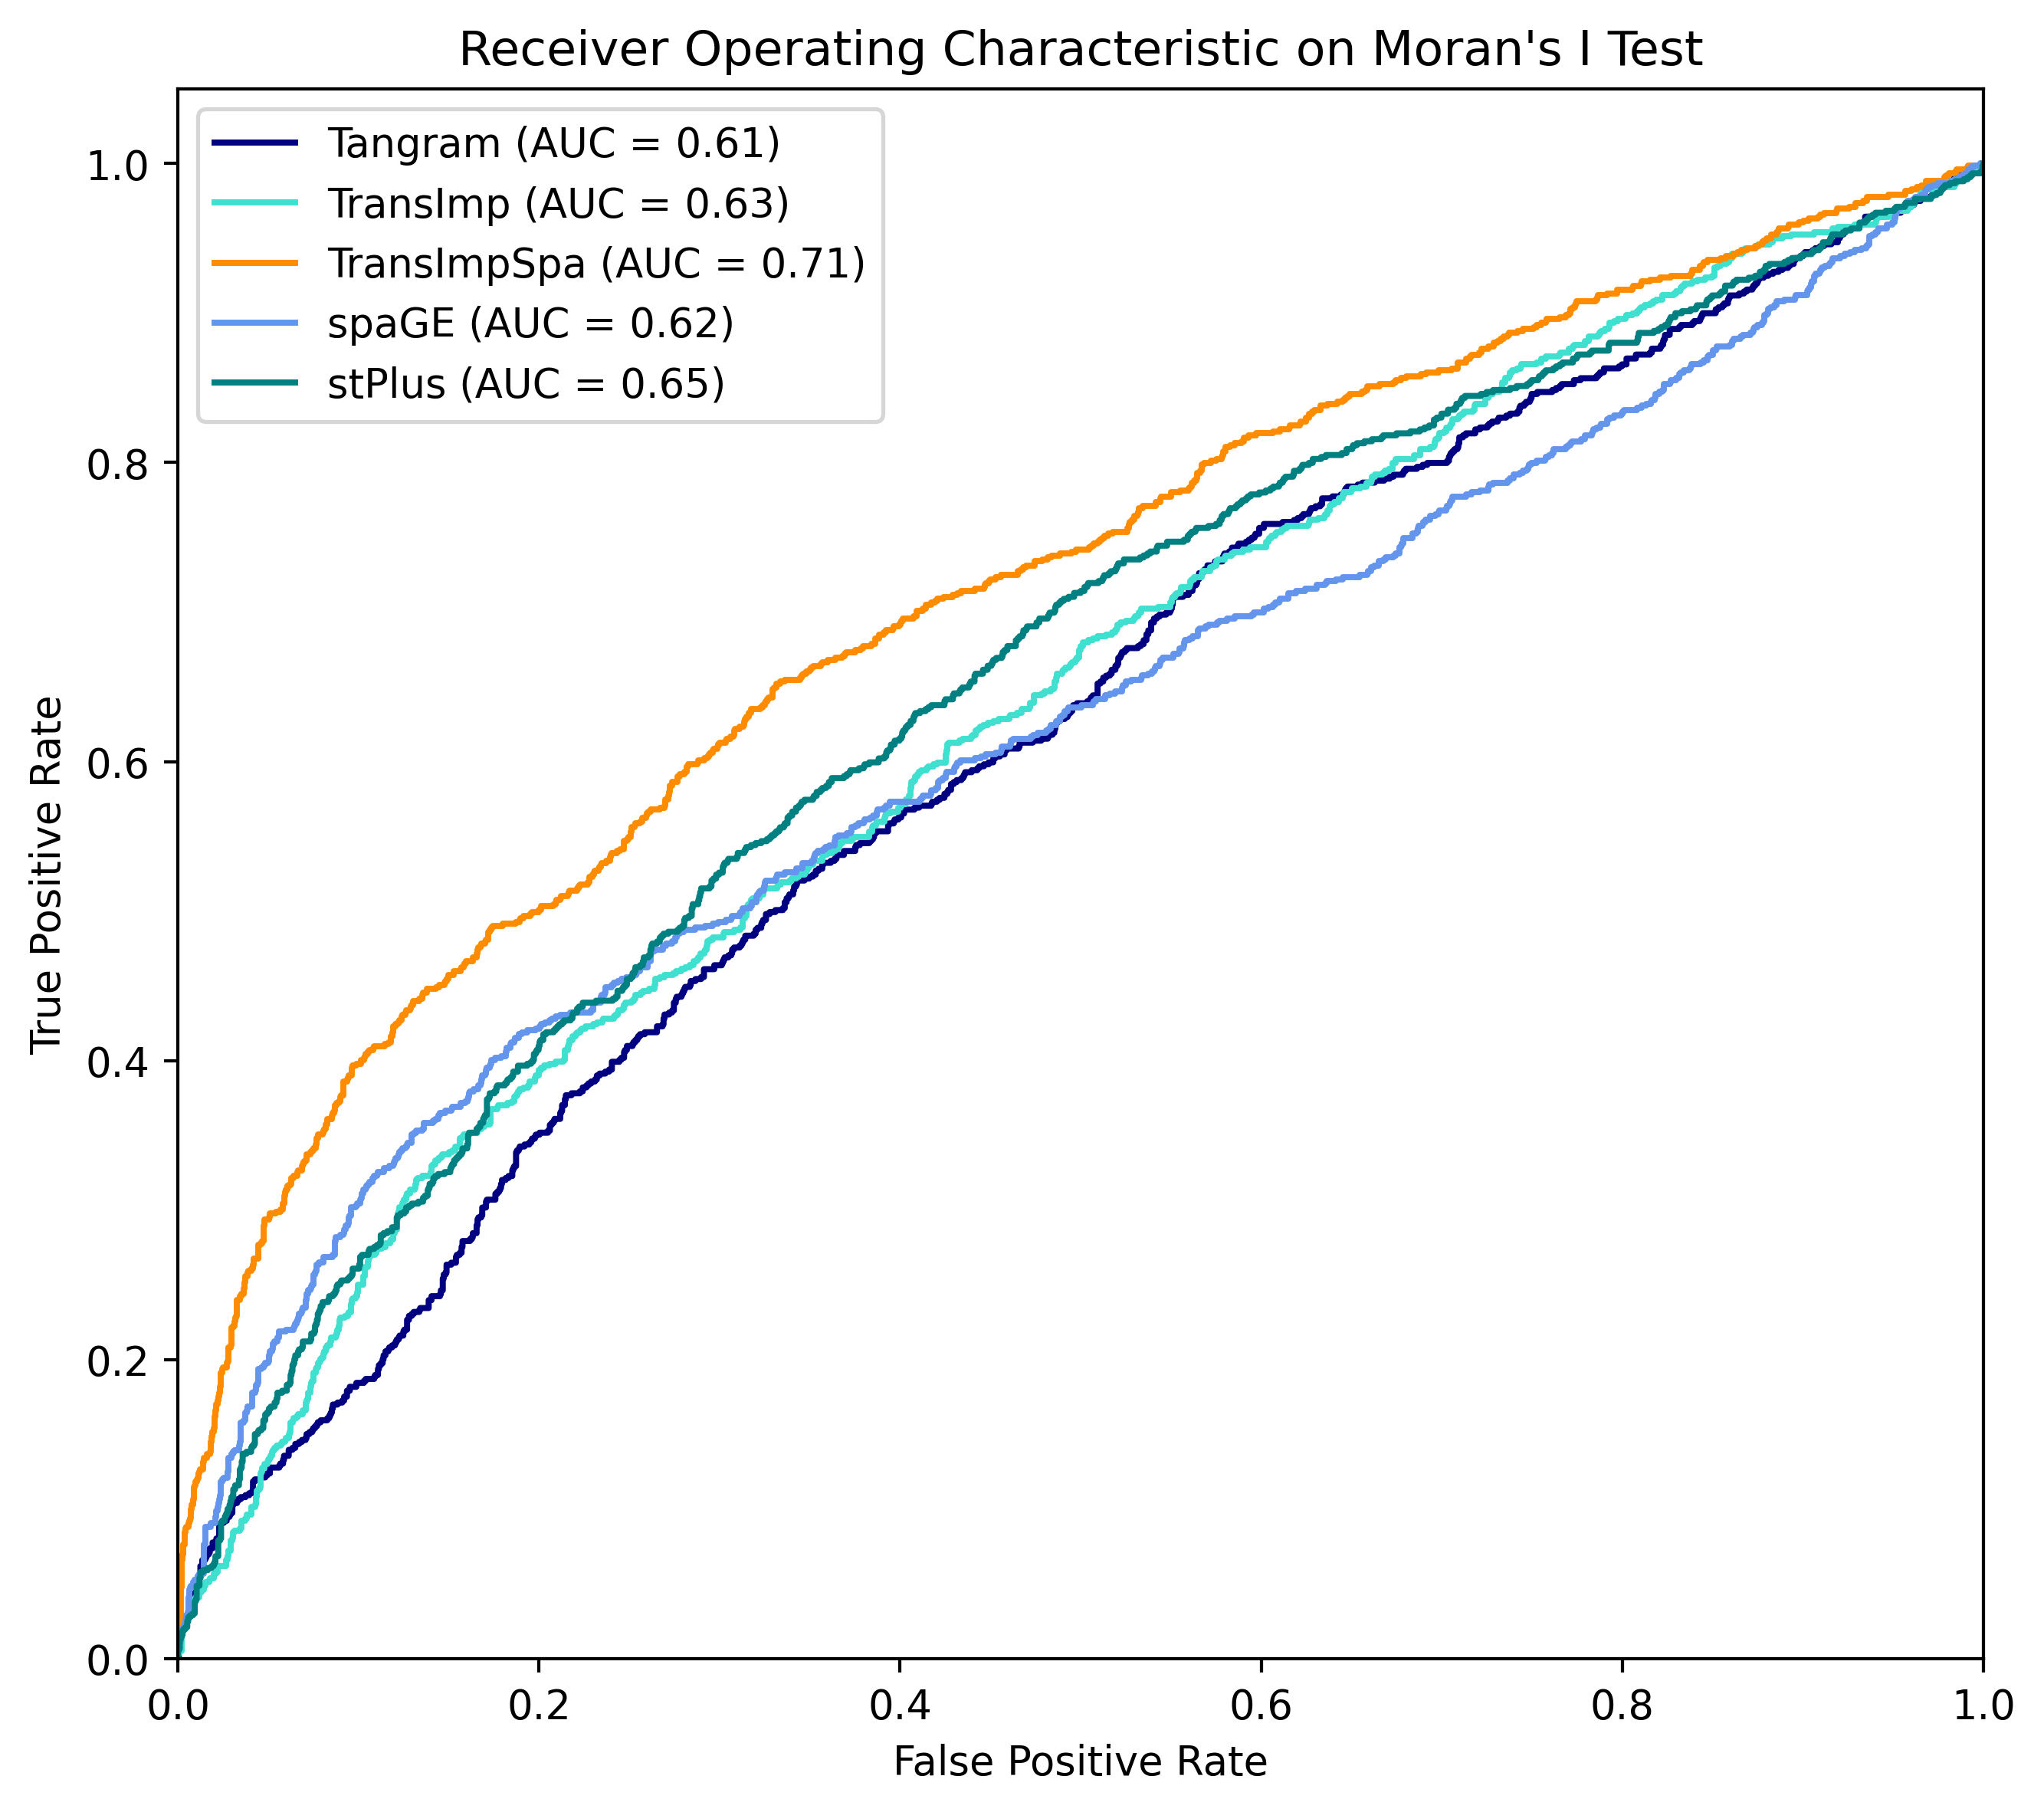

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

In [13]:
fprs = []
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue

    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0) 
    
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
    score = df_I[method][sel]
    # score = -np.log(df_pval[method][sel] + min(df_pval[method][sel].min()/1e6, 1e-300))
    # score[np.isinf(score)] = score[~np.isinf(score)].max()*10
    print(method)
    preds = method_pval < thred
    
    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    
    if not method in {"transImpCls", 'truth',  "transImpClsSpa"}:
        fprs.append({"Method": method, 'False Positive Rate':cm[0][1]/(cm[0][1] + cm[0][0]), "Test": "Moran's I"})
        idx += 1
    else:
        continue
    
    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    plt.figure()
    lw = 2
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    disp.plot(ax=ax, name=f"{method} (AUC = {metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on Moran's I Test")
ax.legend(loc="best")
plt.show()


(Tangram) Valid genes: 2681/5380
Tangram
FPR: 0.986993
prec: 0.28522984174830446, recl: 0.997364953886693,  F1: 0.4435980076179314
(TransImp) Valid genes: 2681/5380
TransImp
FPR: 0.984912
prec: 0.2853907134767837, recl: 0.9960474308300395,  F1: 0.44366197183098594
(TransImpSpa) Valid genes: 2681/5380
TransImpSpa
FPR: 0.133195
prec: 0.2448377581120944, recl: 0.10935441370223979,  F1: 0.151183970856102
(spaGE) Valid genes: 2681/5380
spaGE
FPR: 0.903746
prec: 0.2907309105757452, recl: 0.9380764163372859,  F1: 0.44389027431421446
(stPlus) Valid genes: 2681/5380
stPlus
FPR: 0.000000
prec: 0.0, recl: 0.0,  F1: 0.0
(TransImpCls) Valid genes: 2681/5380
TransImpCls
FPR: 0.992196
prec: 0.28442776735459663, recl: 0.9986824769433466,  F1: 0.44275700934579443
(TransImpClsSpa) Valid genes: 2681/5380
TransImpClsSpa
FPR: 0.000000
prec: 0.0, recl: 0.0,  F1: 0.0


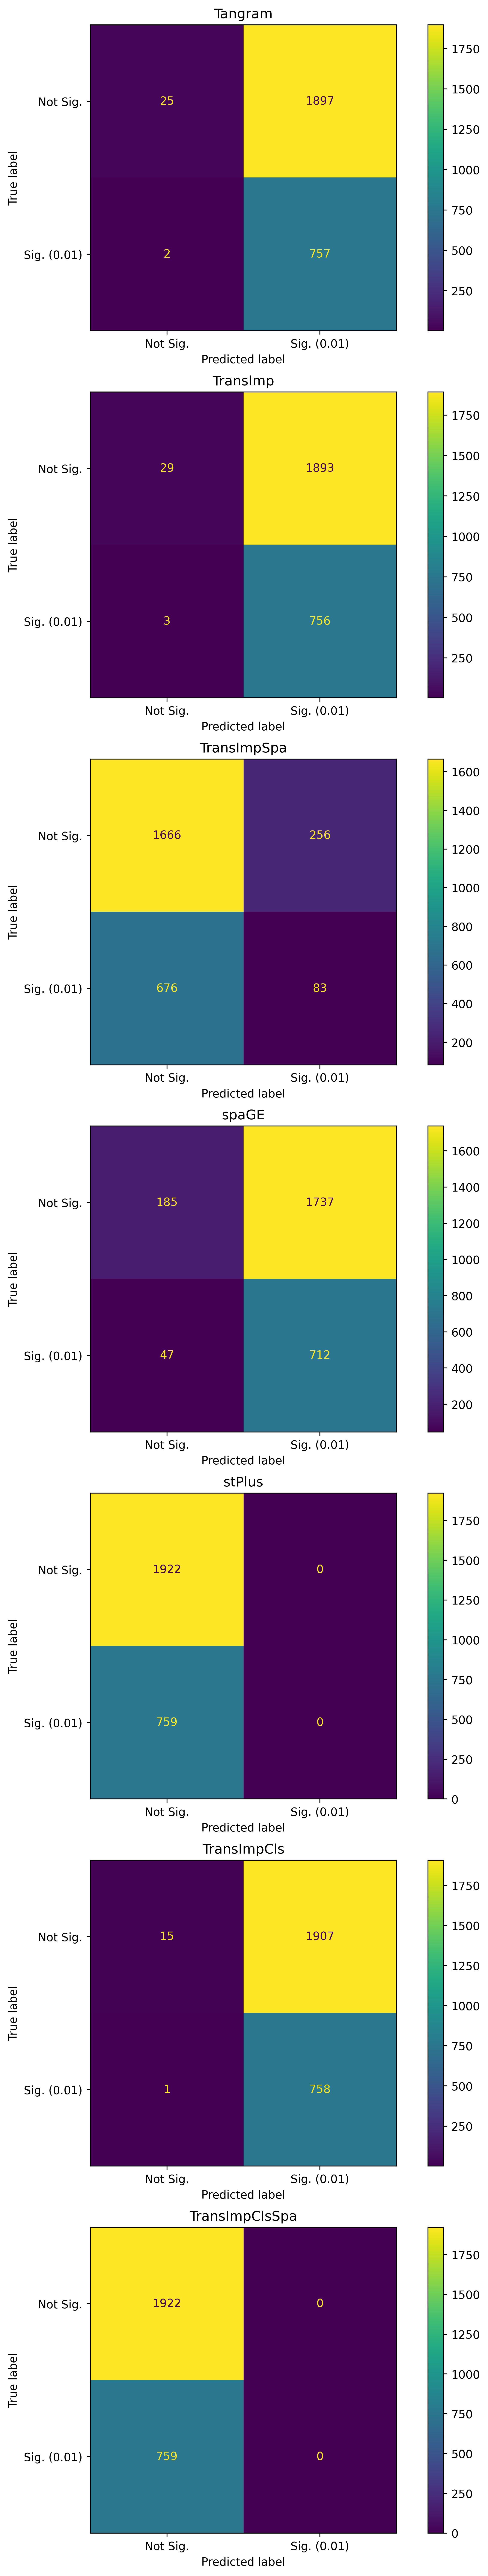

In [14]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in methods:
    # predict zero, 1-score
    if method == "truth": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    # else:
        # continue
    sel = (~np.isnan(df_I['truth'].values) ) & (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0) # & (df_issig.truth.values == 0)
    # sel = sel & (spa_adata[:, df_I.index.values].uns['moranI'].pval_norm_fdr_bh.values < thred)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, pred_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
    # score = df_I[method][sel]
    
    print(method)
    preds = pred_pval < thred
    # print("precision ", metrics.precision_score(y < thred, preds))
    # print("recall", metrics.recall_score(y < thred , preds))
    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

In [15]:
# !Rscript sparkX.r
!/mnt/chenqiao/nfs_share/software/anaconda3/envs/r-environment/bin/Rscript sparkX.r melanoma5fold

[1] "truth"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 293 
## number of total genes: 5380 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With Cosine Kernel 5
[1] "stPlus"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 293 
## number of total genes: 5373 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With

In [16]:
dict_sparkx_cmbpvals = {}
dict_sparkx_adjpvals = {}
ca_genes = None

for md in methods:
    print(md)
    df = pd.read_csv(f"../../output/sparkx_{ST_name}_{md}.csv", header=0, index_col=0)
    if ca_genes is None:
        ca_genes = df.index.values
    
    shared_gene = np.intersect1d(ca_genes, df.index.values)
    if len(shared_gene) < len(ca_genes):
        miss_gene  = np.setdiff1d(ca_genes, shared_gene)
        df = pd.concat([df, pd.DataFrame({"combinedPval":{g:1.0 for g in miss_gene},"adjustedPval":{g:1.0 for g in miss_gene} })], axis=0)
    dict_sparkx_cmbpvals[md] = df.loc[ca_genes, 'combinedPval']
    dict_sparkx_adjpvals[md] = df.loc[ca_genes, 'adjustedPval']
df_sparkx_cmbpvals = pd.DataFrame(dict_sparkx_cmbpvals)
df_sparkx_adjpvals = pd.DataFrame(dict_sparkx_adjpvals)
df_sparkx_cmbpvals, df_sparkx_adjpvals
    

truth
Tangram
TransImp
TransImpSpa
spaGE
stPlus
TransImpCls
TransImpClsSpa


(                truth       Tangram      TransImp   TransImpSpa         spaGE  \
 A1BG     1.214570e-01  2.339571e-25  1.851791e-24  1.861511e-11  1.912915e-18   
 A2M      1.366957e-10  5.098831e-28  3.915155e-32  3.496348e-17  5.040413e-13   
 A4GALT   3.096779e-01  6.439294e-15  3.117861e-19  4.135529e-06  7.547518e-04   
 AAED1    9.401658e-01  4.855086e-19  4.440892e-16  1.337951e-01  3.223511e-09   
 AAK1     3.915469e-01  2.815385e-06  4.669421e-21  7.279197e-03  4.996004e-14   
 ...               ...           ...           ...           ...           ...   
 ZSCAN5A  9.669695e-01  1.406536e-06  1.180495e-07  4.485302e-02  3.702878e-07   
 ZSWIM5   7.594098e-02  1.252537e-07  8.142950e-09  4.333131e-01  4.138106e-02   
 ZSWIM6   2.587926e-01  5.847650e-07  8.757248e-05  3.815069e-02  1.532070e-06   
 ZSWIM7   5.555882e-01  9.266590e-08  1.265978e-09  3.521887e-02  1.832534e-06   
 ZUFSP    9.318949e-01  4.878180e-06  2.406802e-04  9.312550e-02  3.927802e-05   
 
              

(Tangram) Valid genes: 5380/5380
Tangram
FPR: 0.916849
(TransImp) Valid genes: 5380/5380
TransImp
FPR: 0.948478
(TransImpSpa) Valid genes: 5380/5380
TransImpSpa
FPR: 0.334792
(spaGE) Valid genes: 5380/5380
spaGE
FPR: 0.713945
(stPlus) Valid genes: 5380/5380
stPlus
FPR: 0.881241


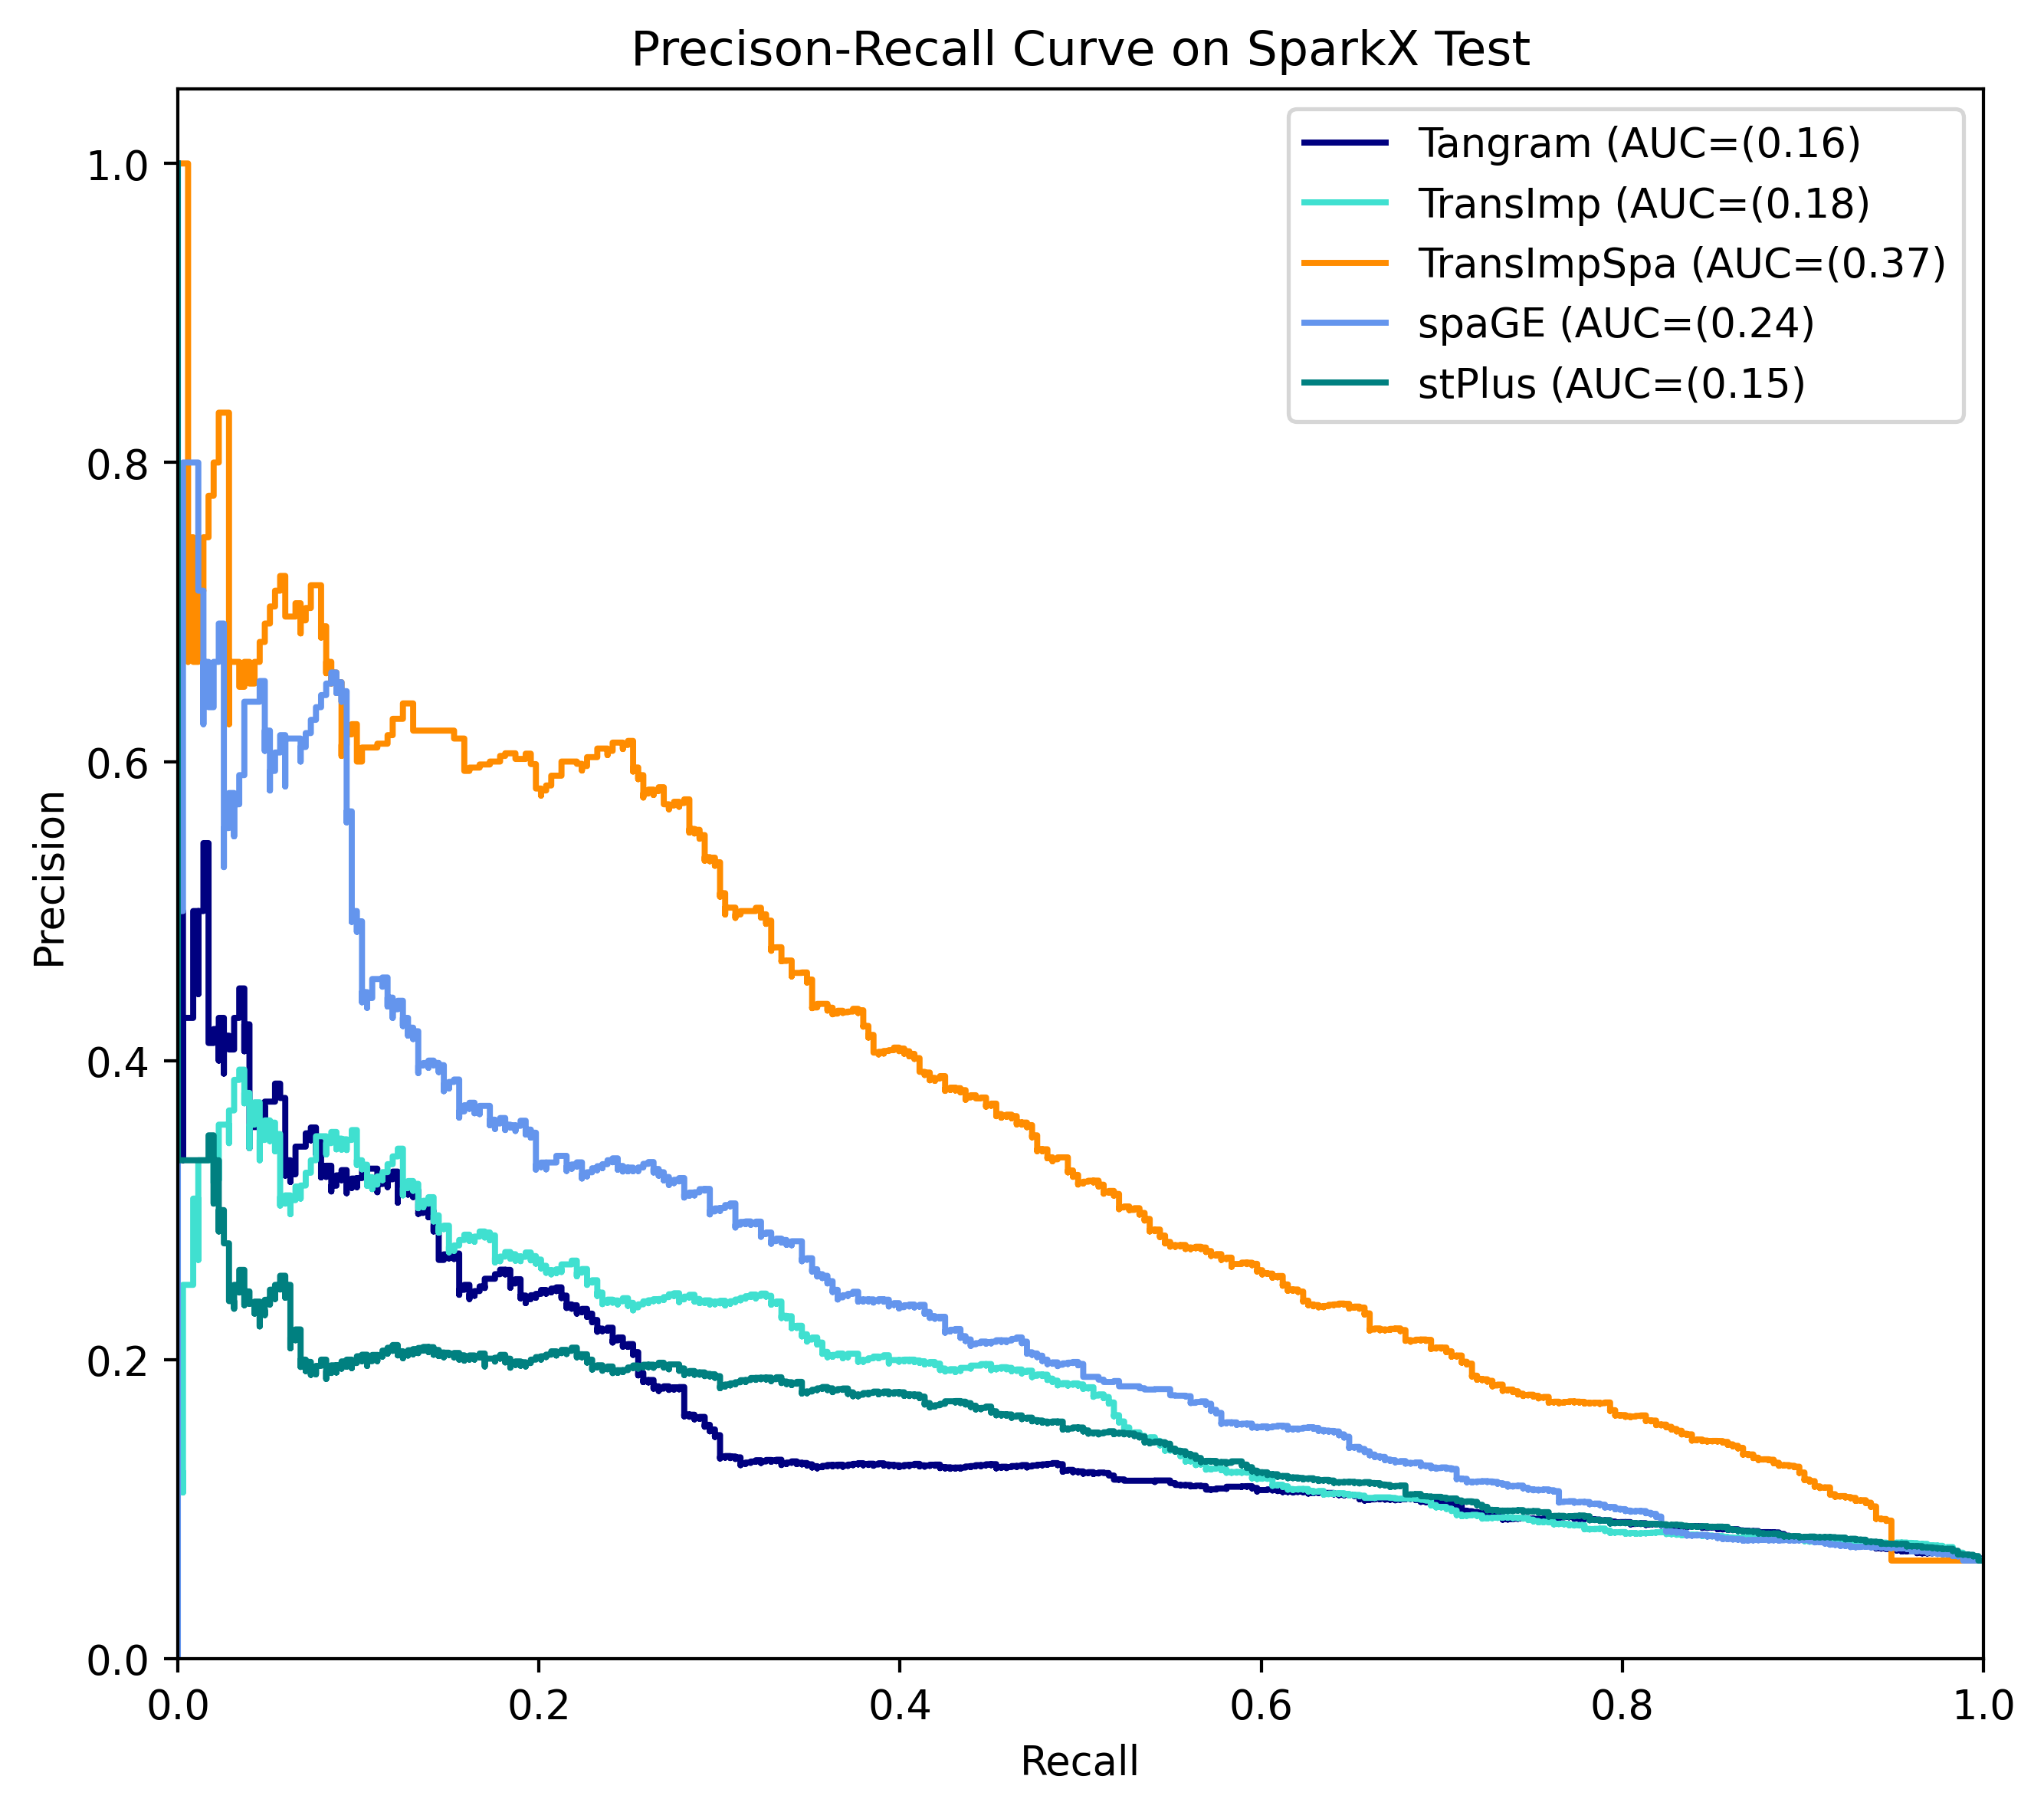

In [17]:
from sklearn import metrics
from matplotlib import pyplot as plt

thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue
    
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_cmbpvals[method][sel].values
    score = -np.log(df_sparkx_adjpvals[method][sel].values + min(np.min(df_sparkx_adjpvals[method][sel].values) * 1e-3, 1e-500))
    
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "truth", "transImpClsSpa"}:
        idx += 1
    else:
        continue      
    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
       
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 5380/5380
Tangram
FPR: 0.916849
(TransImp) Valid genes: 5380/5380
TransImp
FPR: 0.948478
(TransImpSpa) Valid genes: 5380/5380
TransImpSpa
FPR: 0.334792
(spaGE) Valid genes: 5380/5380
spaGE
FPR: 0.713945
(stPlus) Valid genes: 5380/5380
stPlus
FPR: 0.881241


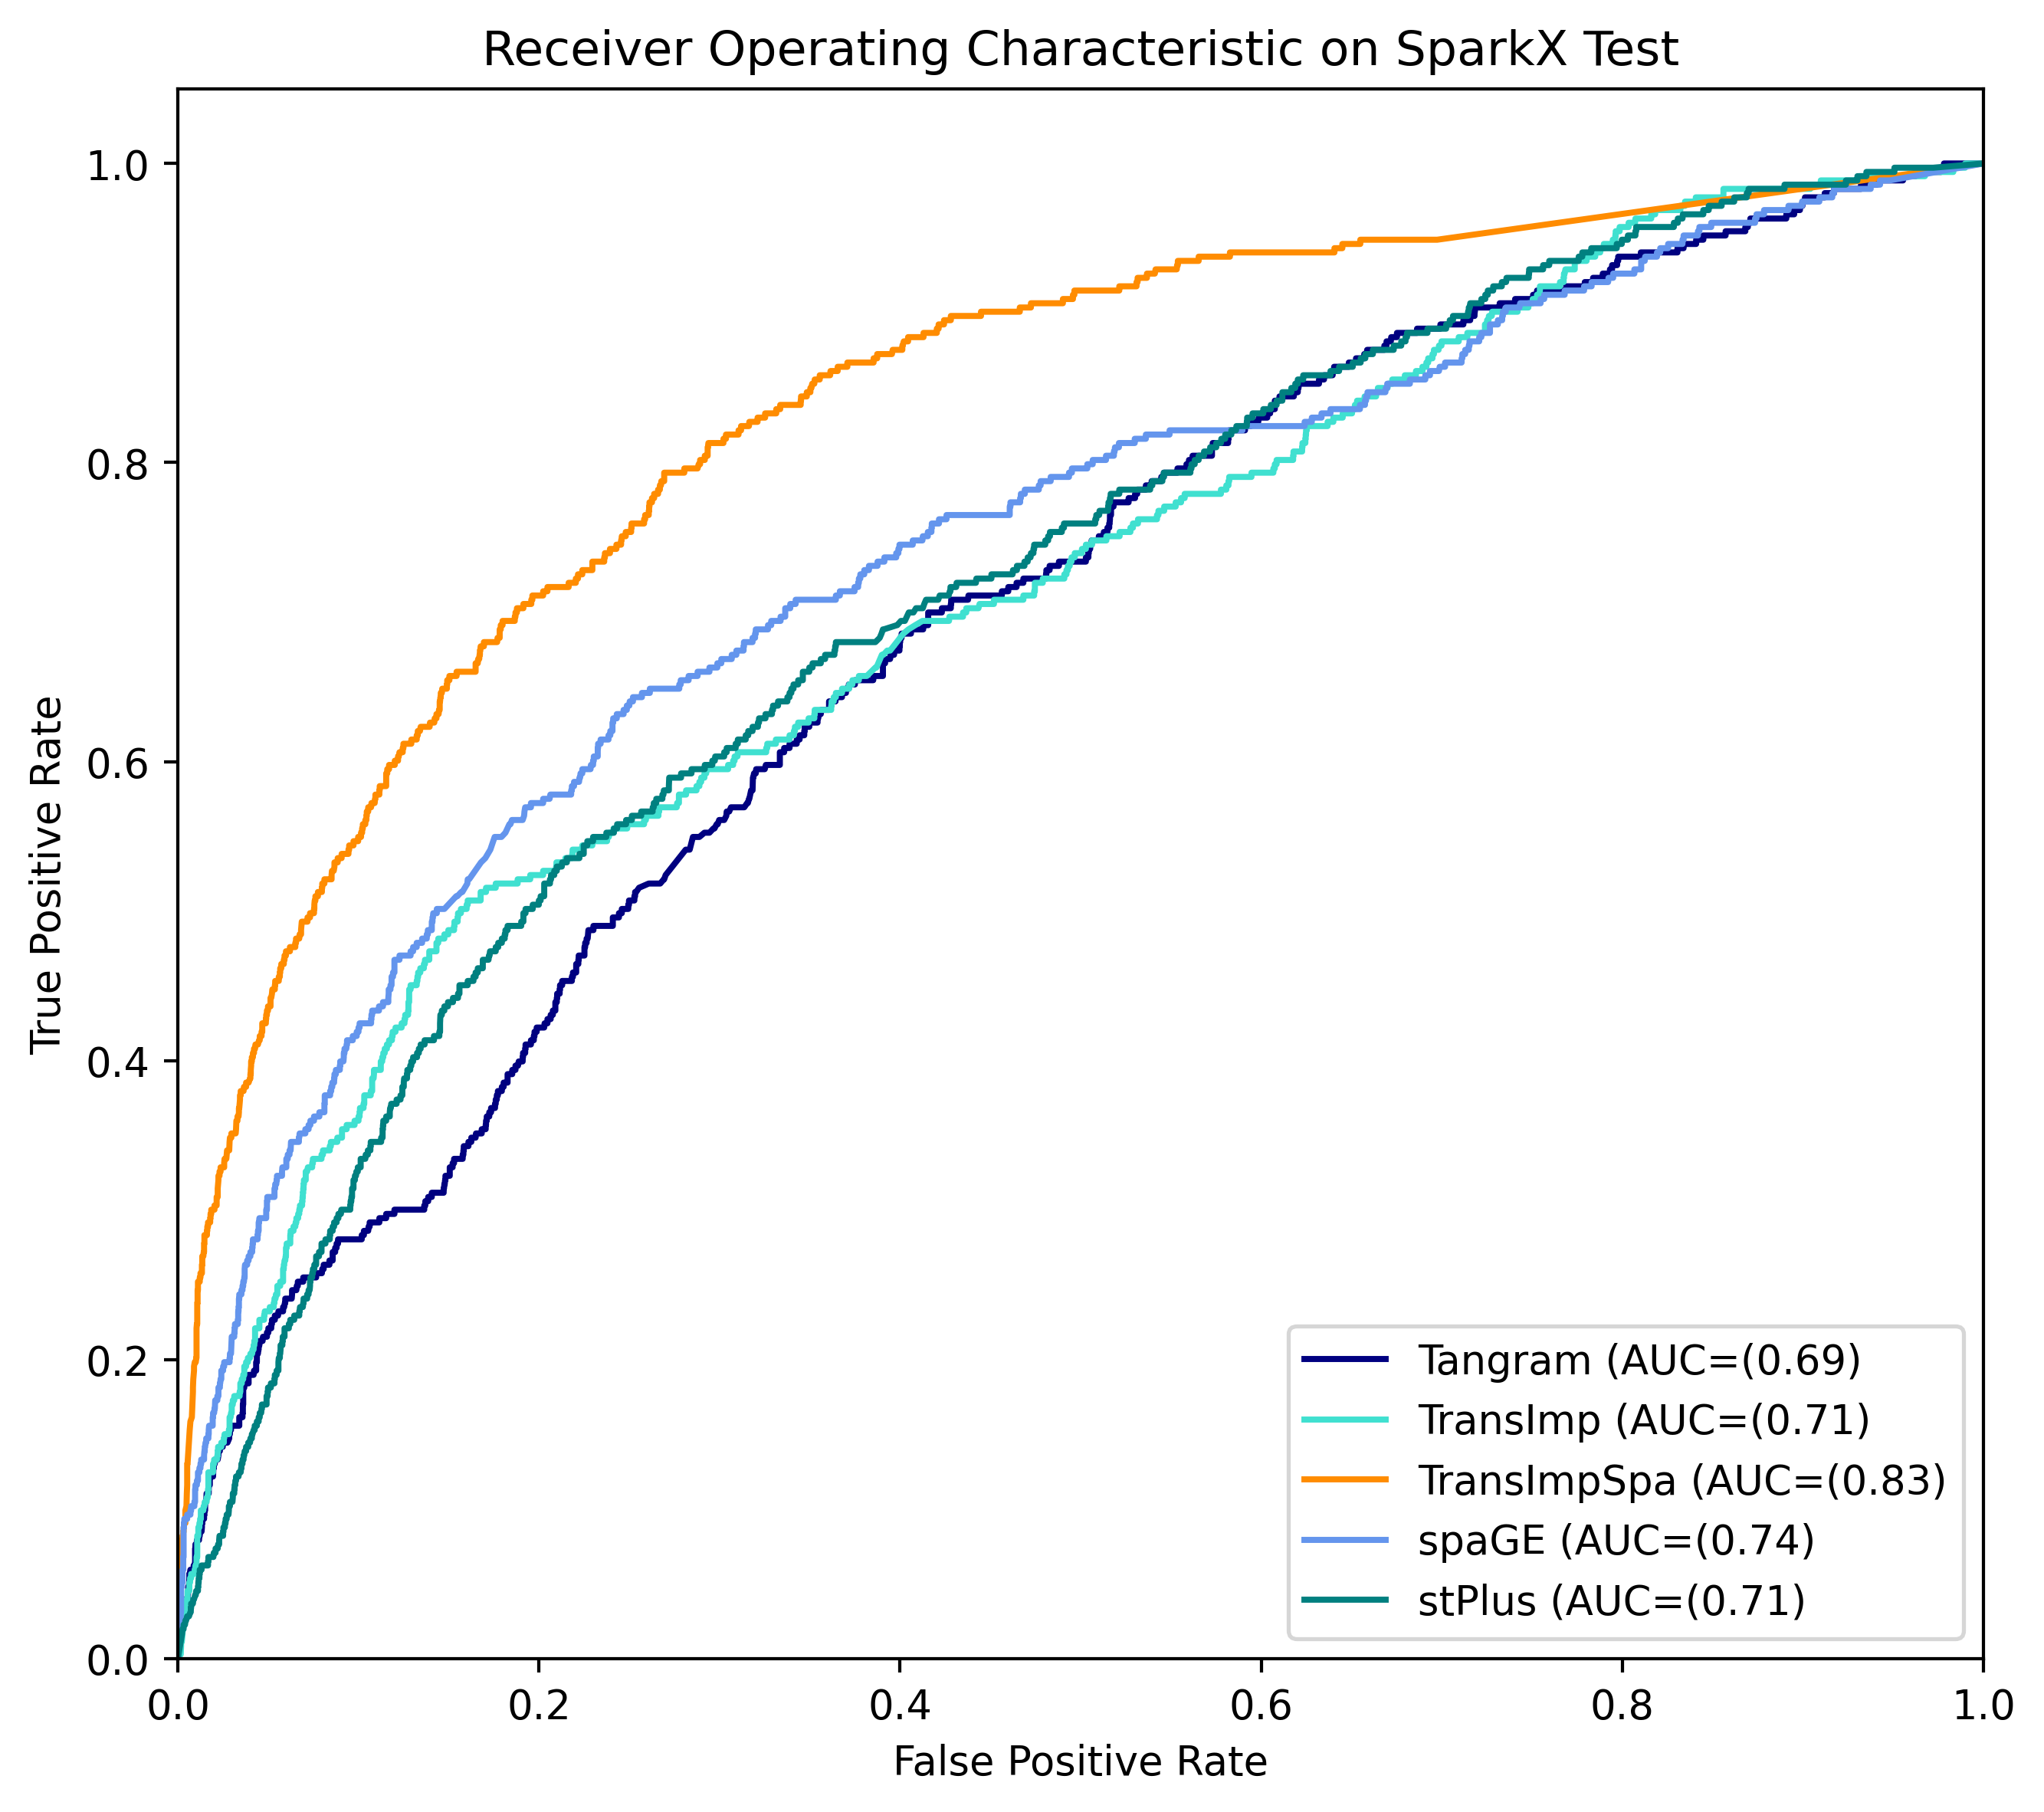

In [18]:
from sklearn import metrics
from matplotlib import pyplot as plt
thred = 0.01
idx = -1

plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_cmbpvals[method][sel].values
    score = -np.log(df_sparkx_adjpvals[method][sel].values + min(np.min(df_sparkx_adjpvals[method][sel].values) * 1e-3, 1e-500))
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "truth", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    
    auc_score = metrics.auc(fpr, tpr)
    
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 5380/5380
Tangram
FPR: 0.916849
prec: 0.0698284561049445, recl: 0.9801699716713881,  F1: 0.1303692539562924
(TransImp) Valid genes: 5380/5380
TransImp
FPR: 0.948478
prec: 0.06838608831574834, recl: 0.9915014164305949,  F1: 0.12794735880095048
(TransImpCls) Valid genes: 5380/5380
TransImpCls
FPR: 0.950070
prec: 0.06809756097560976, recl: 0.9886685552407932,  F1: 0.12741876597298282
(TransImpClsSpa) Valid genes: 5380/5380
TransImpClsSpa
FPR: 0.641735
prec: 0.08689499009340504, recl: 0.8696883852691218,  F1: 0.15800308800823468
(TransImpSpa) Valid genes: 5380/5380
TransImpSpa
FPR: 0.334792
prec: 0.14957049014653864, recl: 0.8385269121813032,  F1: 0.2538593481989708
(spaGE) Valid genes: 5380/5380
spaGE
FPR: 0.713945
prec: 0.0792714212416624, recl: 0.8753541076487252,  F1: 0.14537755822159493
(stPlus) Valid genes: 5380/5380
stPlus
FPR: 0.881241
prec: 0.0726397320494034, recl: 0.9830028328611898,  F1: 0.13528265107212478


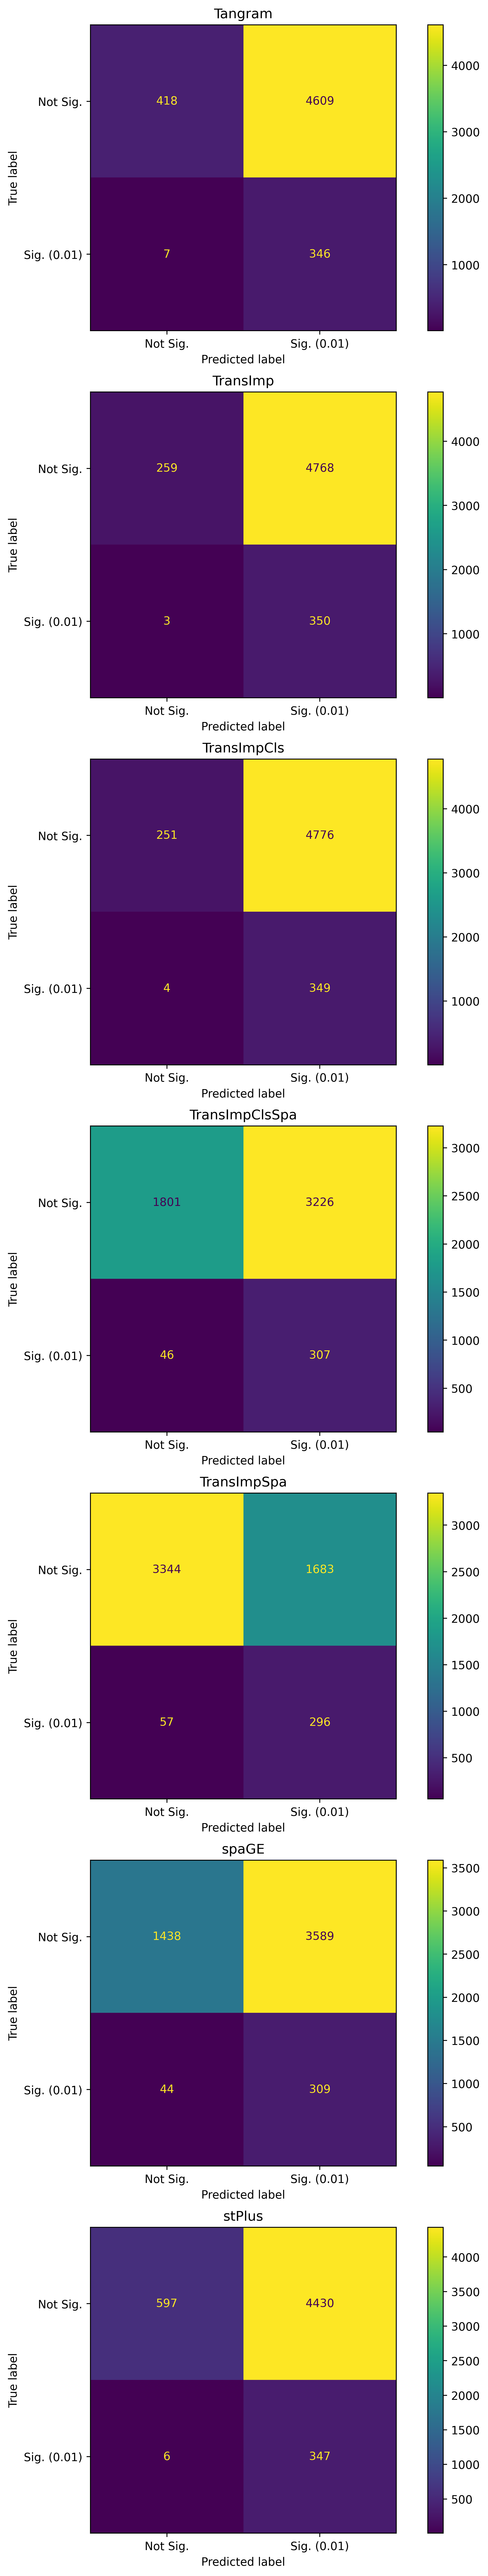

In [19]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method == "truth": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

In [20]:
from scipy import sparse
def merge_data(imp_adata, adata):
    valid_genes = [g for g in adata.var_names if g not in imp_adata.var_names]
    print(f"Valid genes: {len(valid_genes)}, Ex genes: {imp_adata.shape[1]}")
    X = adata[:, valid_genes].X
    if sparse.issparse(X):
        X = X.toarray()
    X = np.hstack([X, imp_adata.X])
    m_adata = sc.AnnData(X, dtype=np.float32)
    m_adata.var_names = np.concatenate([valid_genes, imp_adata.var_names.values])
    return m_adata
def read_data(imp_adatas):
    spa_adata = sc.read_h5ad("../../data/ST/melanoma/spatial.h5ad")
    spa_adata = spa_adata[:, (spa_adata.var_names.values != 'MARCH1') & (spa_adata.var_names.values != 'MARCH2')].copy()
    adatas = {}
    for method in methods:
        adatas[method] = merge_data(imp_adatas[method], spa_adata)
        adatas[method].obsm['spatial'] = spa_adata.obsm['spatial'].copy()
    return adatas

m_adatas = read_data(dict_adata)

Valid genes: 10766, Ex genes: 5380
Valid genes: 10766, Ex genes: 5380
Valid genes: 10766, Ex genes: 5380
Valid genes: 10766, Ex genes: 5380
Valid genes: 10766, Ex genes: 5380
Valid genes: 10766, Ex genes: 5380
Valid genes: 10766, Ex genes: 5380
Valid genes: 10766, Ex genes: 5380


In [21]:
def spatialdm(adata, spec, l):
    sdm.weight_matrix(adata,  n_nearest_neighbors=4, l=l, cutoff=0.2, single_cell=False)
    # find overlapping LRs from CellChatDB
    sdm.extract_lr(adata, spec, min_cell=0)
    # global Moran selection
    # print(adata.uns)
    # print(adata)
    cp_adata = None
    try:
        sdm.spatialdm_global(adata, 10, specified_ind=None, method='both', nproc=10)
        sdm.sig_pairs(adata, method='z-score', fdr=True, threshold=0.1)        
    except Exception as e:
        # print(e)
        cp_adata = adata.copy()
        sdm.extract_lr(cp_adata, spec, min_cell=1)
        sdm.spatialdm_global(cp_adata, 10, specified_ind=None, method='both', nproc=10)
        sdm.sig_pairs(cp_adata, method='z-score', fdr=True, threshold=0.1)
    # select significant pairs
    if not cp_adata is None:
        full_set = adata.uns['geneInter'].interaction_name
        # print(np.intersect1d(full_set, cp_adata.uns['global_res'].index.values))
        full_global_res = cp_adata.uns['global_res'].copy()
        full_global_res['global_I'] = cp_adata.uns['global_I'].copy()
        for pair in full_set:
            if pair not in cp_adata.uns['global_res'].index.values:
                # z	perm_pval	fdr	selected
                full_global_res = pd.concat([full_global_res, pd.DataFrame({
                    "Ligand0":{pair:pair.split("_")[0]},
                    "Receptor0":{pair:pair.split("_")[1]},
                    "Receptor1":{pair:None},
                    "z_pval":{pair:0.99 + np.random.rand() * 0.01},
                    "z":{pair:np.random.rand()*0.01},
                    "perm_pval":{pair:0.99 + np.random.rand() * 0.01},
                    "fdr":{pair:0.99 + np.random.rand() * 0.01},
                    "selected":{pair:False},
                    "global_I":{pair:np.random.rand() * 1e-6},
                })])
        # print(np.intersect1d(full_global_res.index, cp_adata.uns['global_res'].index.values))        
        adata.uns['global_res'] = full_global_res.loc[adata.uns['geneInter'].interaction_name].copy()
        adata.uns['global_I'] = full_global_res.global_I.values
        
        
    valid_genes = [True if l != r else False for l,r in zip(adata.uns['global_res'].Ligand0, adata.uns['global_res'].Receptor0)]
    print(len(valid_genes), adata.uns['global_res'].shape[0])
    sel = adata.uns['global_res'].index[valid_genes]
    adata.uns['global_res'] = adata.uns['global_res'].loc[sel]
    adata.uns['global_I'] = adata.uns['global_I'][valid_genes]
    adata.uns['global_res'].sort_values(by='fdr')
    print(adata.uns['global_res'].shape)
for md in m_adatas:
    spatialdm(m_adatas[md], "human", 1.2)    

100%|██████████| 10/10 [00:00<00:00, 254.16it/s]


1180 1180
(1160, 11)


100%|██████████| 10/10 [00:00<00:00, 241.66it/s]


1180 1180
(1160, 11)


100%|██████████| 10/10 [00:00<00:00, 247.13it/s]


1180 1180
(1160, 11)


100%|██████████| 10/10 [00:00<00:00, 262.13it/s]


1180 1180
(1160, 11)


100%|██████████| 10/10 [00:00<00:00, 271.21it/s]


1180 1180
(1160, 11)


100%|██████████| 10/10 [00:00<00:00, 268.66it/s]


1180 1180
(1160, 12)


100%|██████████| 10/10 [00:00<00:00, 273.95it/s]


1180 1180
(1160, 11)


100%|██████████| 10/10 [00:00<00:00, 277.11it/s]

1180 1180
(1160, 11)


In [22]:
import pickle
with open(f"../../output/{ST_name}_spatialdm.pkl", 'wb') as outfile:
    pickle.dump(m_adatas, outfile)

Tangram # 567 pairs, # sig pairs: (Truth): 142, (Preds) 364
TransImp # 567 pairs, # sig pairs: (Truth): 142, (Preds) 386
TransImpSpa # 567 pairs, # sig pairs: (Truth): 142, (Preds) 329
spaGE # 567 pairs, # sig pairs: (Truth): 142, (Preds) 367
stPlus # 567 pairs, # sig pairs: (Truth): 142, (Preds) 332
TransImpCls # 567 pairs, # sig pairs: (Truth): 142, (Preds) 366
TransImpClsSpa # 567 pairs, # sig pairs: (Truth): 142, (Preds) 377


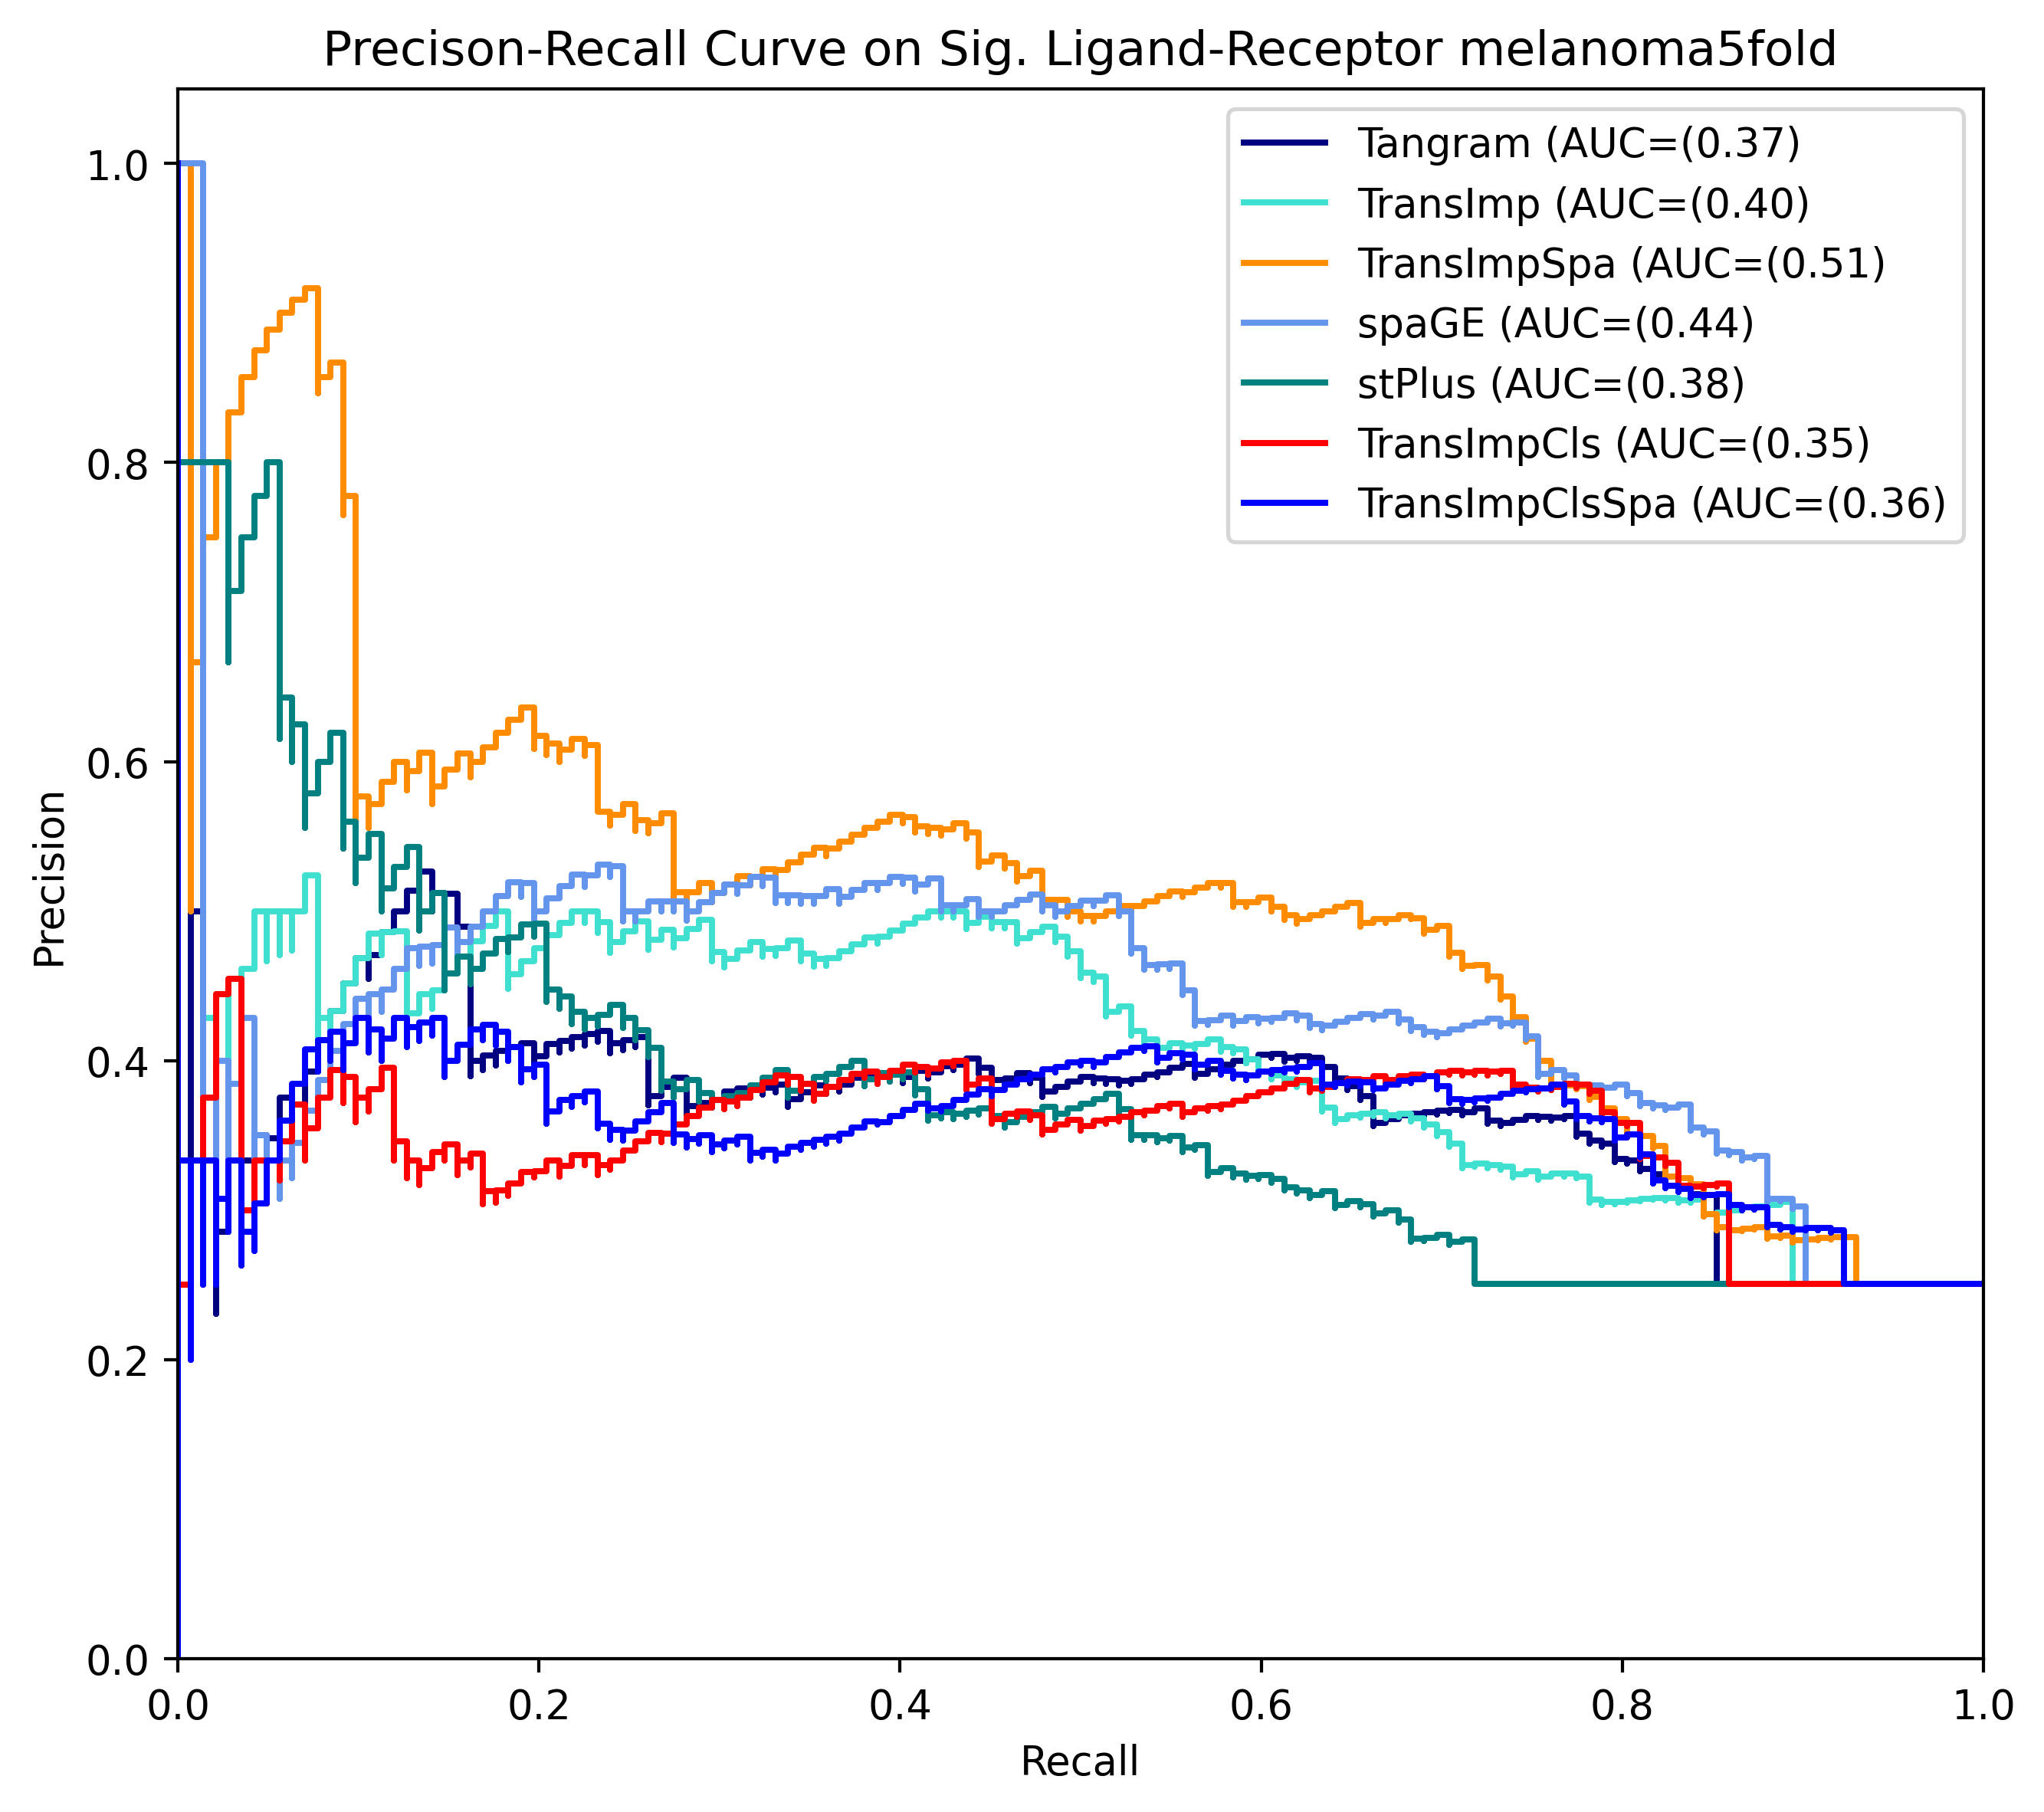

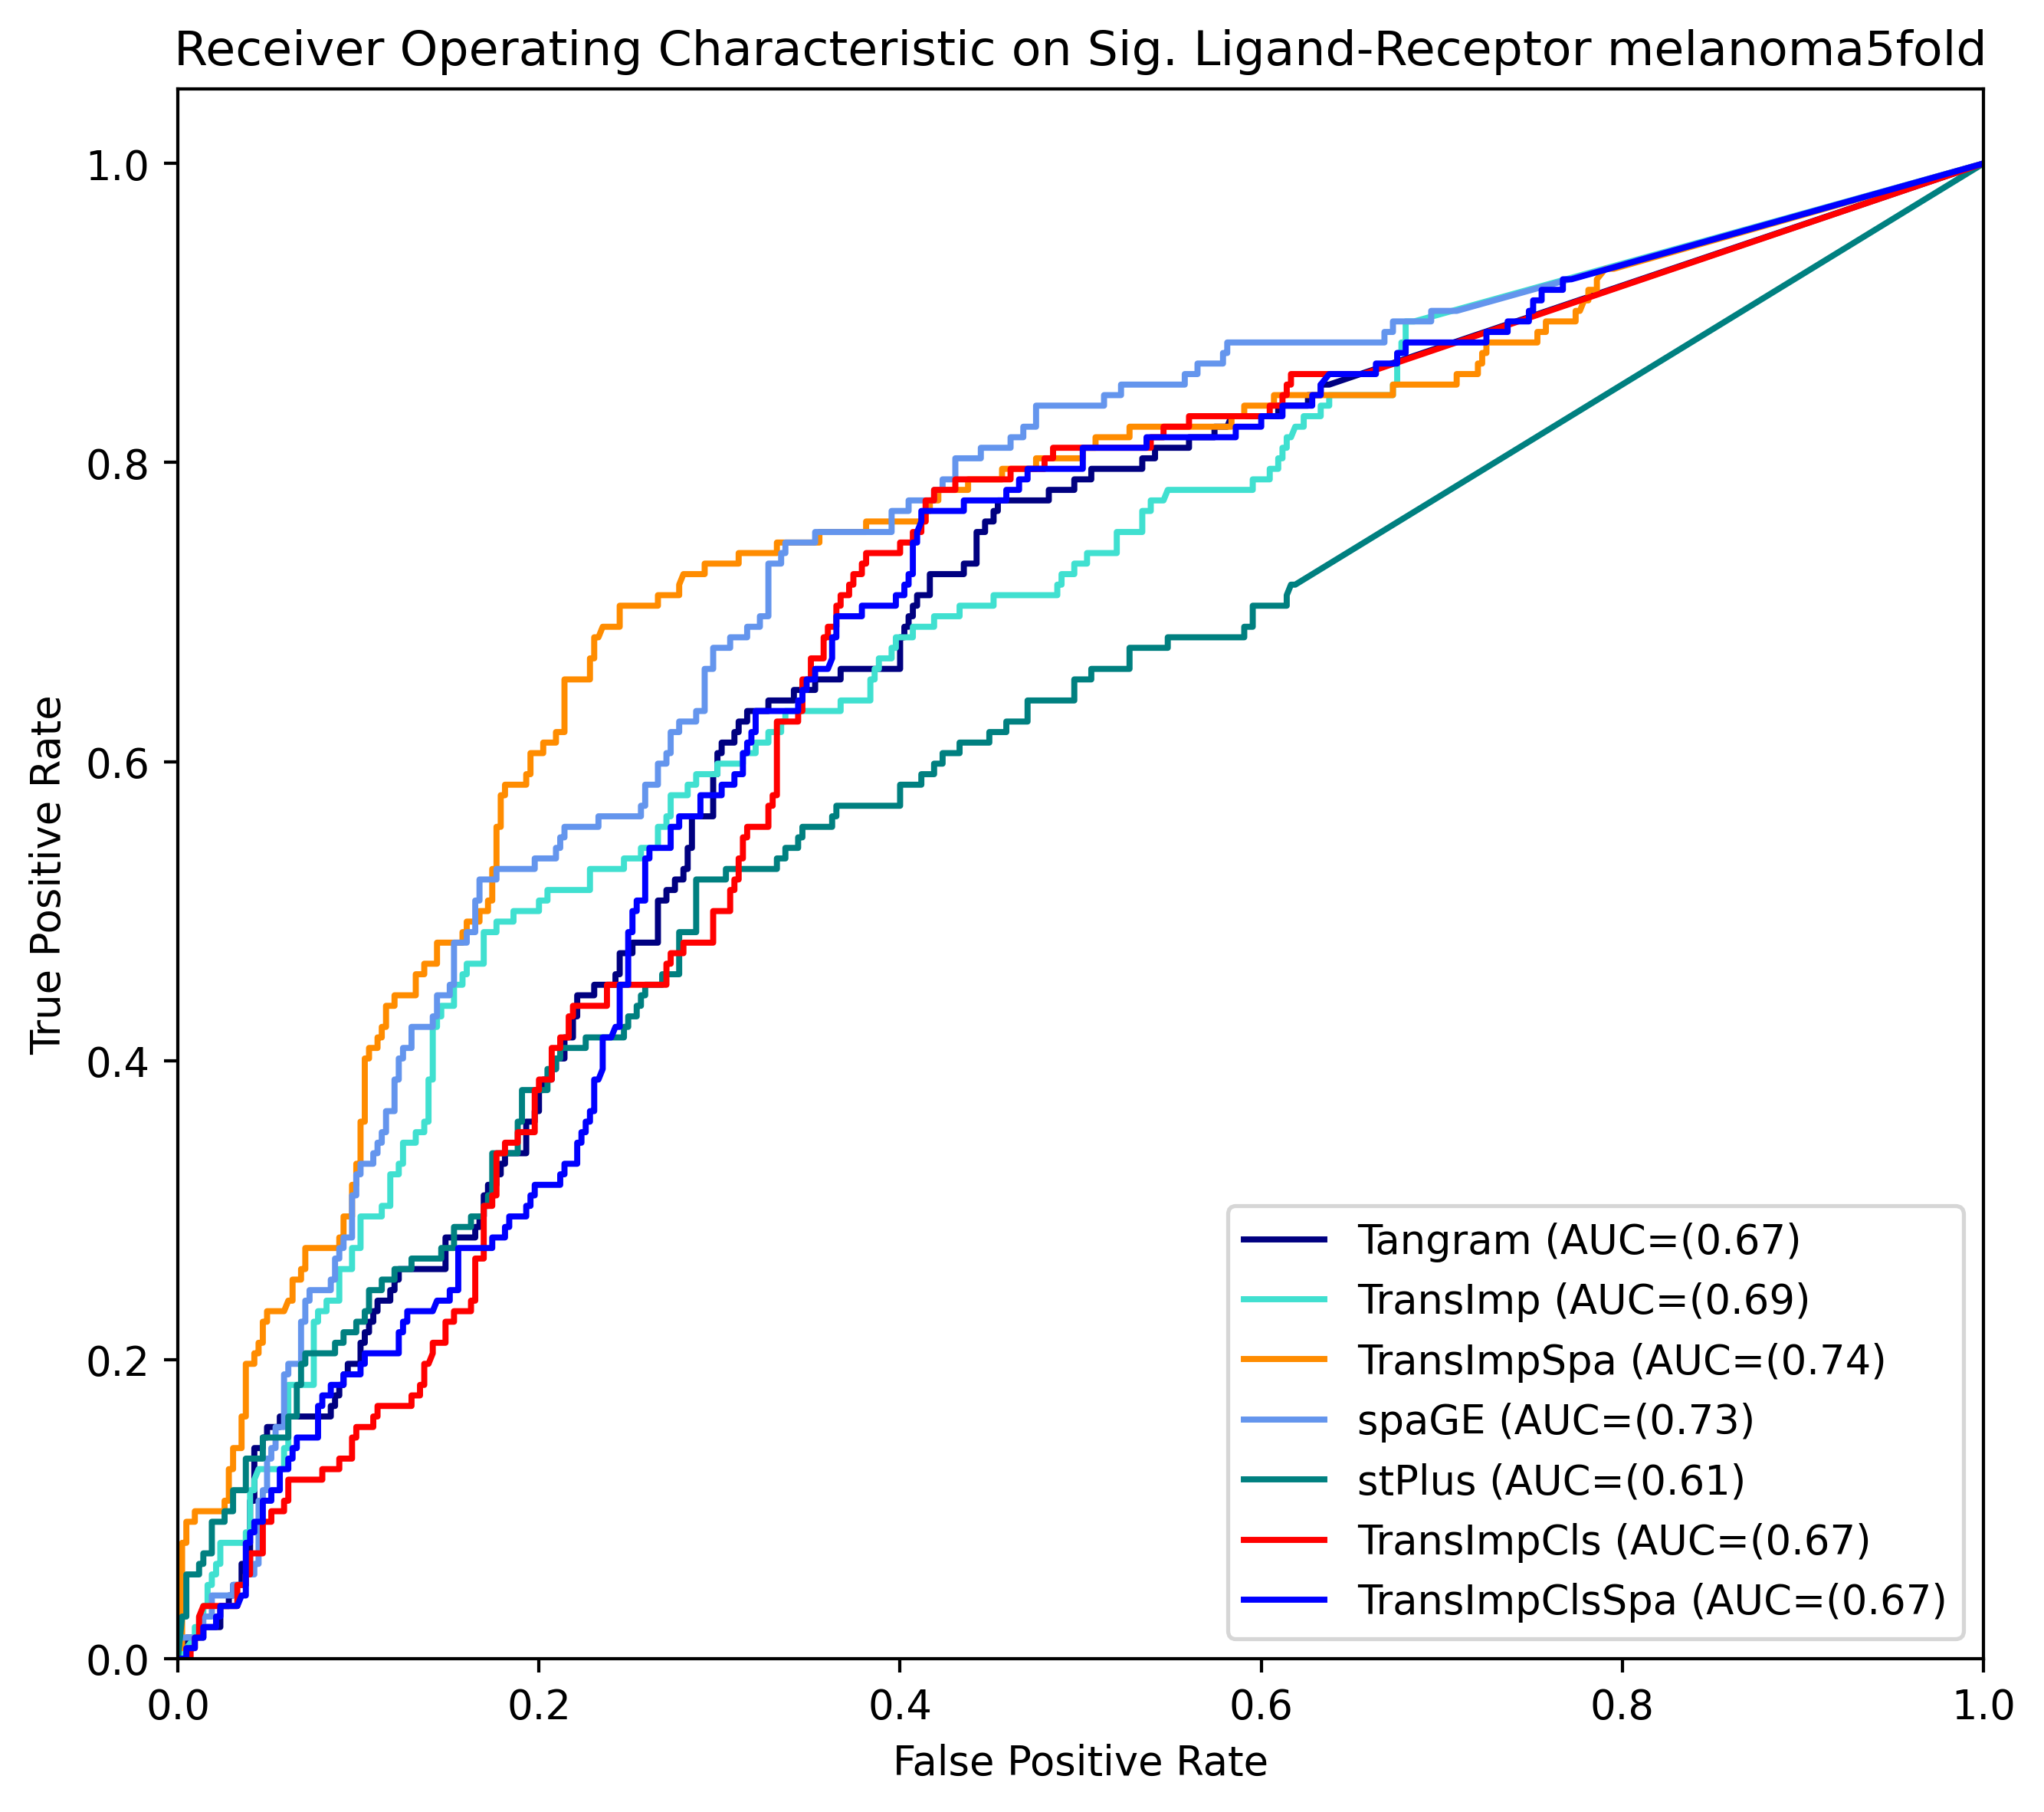

In [23]:
def precision_recall_curve(adatas, dataset_name):
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in methods:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        print(f"{md} # {len(genes)} pairs, # sig pairs: (Truth): {truth_res.loc[genes].selected.values.sum()}, (Preds) {adatas[md].uns['global_res'].loc[genes].selected.values.sum()}")
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        # print(adatas[md].uns['global_res'].loc[genes].fdr.values)
        # print(np.max(adatas[md].uns['global_res'].loc[genes].fdr.values), np.min(adatas[md].uns['global_res'].loc[genes].fdr.values))
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + min(np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # new_scores = list(range(len(score)))
        # score = np.array([new_scores[idx] for idx in np.argsort(score)])
        # plt.hist(score, bins=100);plt.show()
        # score = expit(score)
        # plt.hist(score, bins=100)
        # plt.show()
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        
        prec, rec, thresholds  = metrics.precision_recall_curve(y, score, pos_label=1)
        
        disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.average_precision_score(y, score):.2f})", color=color[idx])
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Precison-Recall Curve on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()   
    
def roc_curve(adatas, dataset_name):     
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in methods:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        # print(np.max(adatas[md].uns['global_res'].loc[genes].fdr.values), np.min(adatas[md].uns['global_res'].loc[genes].fdr.values))
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + min(np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # new_scores = list(range(len(score)))
        # score = np.array([new_scores[idx] for idx in np.argsort(score)])
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # score = expit(score)
        fpr, tpr, thresholds  = metrics.roc_curve(y, score, pos_label=1)
        
        auc_score = metrics.auc(fpr, tpr)
        
        disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
        
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.roc_auc_score(y, score):.2f})", color=color[idx])
        
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Receiver Operating Characteristic on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()
    

precision_recall_curve(m_adatas, ST_name)
roc_curve(m_adatas, ST_name)
